# ECEN 758 Data Mining and Analysis Project - Fall 2025

**Due Date:** November 25, 2025, 11:59 PM CST

**Team Members:**
- Banghyon Lee (Joseph)
- Fahimeh Orvati Nia
- Nandhini Valiveti
- Sushama Perati

**Dataset:** ESC-50

## Project Overview

This notebook contains the complete ESC-50 Environmental Sound Classification project, combining all team members' work:

1. **Feature Extraction and Preprocessing** 
   - Raw features (176 features: MFCC, Chroma, Mel, Contrast, Tonnetz)
   - Normalized features (StandardScaler)
   - Selected features (Top 100 via Mutual Information)

2. **Model Implementations:**
   - **Fahimeh Orvati Nia:** Naive Bayes, CNN
   - **Banghyon Lee (Joseph):** 
     - Random Forest, Gradient Boosting, XGBoost (on traditional features)
     - Transfer Learning with YAMNet + Random Forest
     - MLP on YAMNet embeddings
     - Self-Supervised Learning (Pseudo-Labeling) with threshold sweep
   - **Nandhini Valiveti:** SVM (Linear & RBF), MLP
   - **Sushama Perati:** Logistic Regression, KNN

3. **Evaluation:** 
   - All models tested on Raw, Normalized, and Selected feature sets
   - Comprehensive metrics: Accuracy, Precision, Recall, F1-score
   - Visualizations: Confusion matrices, learning curves, feature importance, performance heatmaps

## ESC-50 Dataset

The ESC-50 dataset is a labeled collection of 2000 environmental sound recordings, each 5 seconds long. It is divided into 50 classes, with 40 examples per class. The dataset is pre-arranged into 5 folds for cross-validation (folds 1-3: train, fold 4: validation, fold 5: test).


## 1. Project Setup and Data Download


In [1]:
# Install necessary libraries
!pip install -q librosa scikit-learn xgboost tensorflow tensorflow-hub soundfile pandas numpy matplotlib seaborn tqdm


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.37.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.
streamlit 1.37.1 requires pillow<11,>=7.1.0, but you have pillow 11.3.0 which is incompatible.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.33.1 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# Download the ESC-50 dataset
!wget -q https://github.com/karolpiczak/ESC-50/archive/master.zip -O ESC-50.zip
!unzip -q ESC-50.zip
!mv ESC-50-master ESC-50_data
print("Dataset downloaded successfully!")


Dataset downloaded successfully!


## 2. Feature Extraction and Preprocessing 

This section extracts features from audio files using librosa and creates three datasets:
- **Raw features:** 176 features (MFCC, Chroma, Mel, Contrast, Tonnetz)
- **Normalized features:** StandardScaler applied to raw features
- **Selected features:** Top 100 features selected using Mutual Information

**Note:** If feature files already exist, you can skip this section and load them directly.


In [11]:
# Feature Extraction
import os
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
import joblib

# Paths
META_CSV = 'ESC-50_data/meta/esc50.csv'
AUDIO_DIR = 'ESC-50_data/audio'
os.makedirs("data_out", exist_ok=True)

# Check if features already exist
if os.path.exists("data_out/esc50_features_raw.csv"):
    print("Feature files already exist. Loading from disk...")
    df = pd.read_csv("data_out/esc50_features_raw.csv")
    print(f"Loaded raw features: {df.shape}")
else:
    print("Extracting features from audio files...")
    # Load metadata
    meta = pd.read_csv(META_CSV)
    print("Loaded:", meta.shape, "files")

    # Feature extraction function
    def extract_features(file_path):
        y, sr = librosa.load(file_path, sr=None)
        if len(y) > sr*5:
            y = y[:sr*5]

        # Core features
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20), axis=1)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr), axis=1)
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr), axis=1)

        features = np.hstack([mfcc, chroma, mel, contrast, tonnetz])
        return features

    # Extract features for all audio files
    all_features = []
    for _, row in tqdm(meta.iterrows(), total=len(meta), desc="Extracting features"):
        file_path = os.path.join(AUDIO_DIR, row["filename"])
        feats = extract_features(file_path)
        all_features.append({
            "filename": row["filename"],
            "target": row["target"],
            "label": row["category"],
            "fold": row["fold"],
            **{f"f{i}": feats[i] for i in range(len(feats))}
        })

    df = pd.DataFrame(all_features)
    print("Raw feature matrix shape:", df.shape)
    df.to_csv("data_out/esc50_features_raw.csv", index=False)
    print("Saved raw feature file.")


Feature files already exist. Loading from disk...
Loaded raw features: (2000, 177)


In [12]:
# Normalization
if not os.path.exists("data_out/esc50_features_normalized_corrected.csv"):
    print("Creating normalized features...")
    df_raw = pd.read_csv("data_out/esc50_features_raw.csv")
    df_features_only = df_raw.drop(columns=['filename', 'fold'])
    feature_cols = [c for c in df_features_only.columns if c.startswith("f")]

    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(df_features_only[feature_cols])

    normalized_df = pd.DataFrame(normalized_features, columns=feature_cols)
    normalized_df['target'] = df_raw['target']
    normalized_df['label'] = df_raw['label']
    normalized_df['filename'] = df_raw['filename']
    normalized_df['fold'] = df_raw['fold']

    normalized_df.to_csv("data_out/esc50_features_normalized_corrected.csv", index=False)
    joblib.dump(scaler, "data_out/scaler_corrected.pkl")
    print("Saved normalized dataset + scaler")
else:
    print("Normalized features already exist.")


Normalized features already exist.


### Feature Selection Visualization


In [33]:
# Visualize Top 30 Features by Mutual Information
import re
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

# Load raw features
df_raw = pd.read_csv("data_out/esc50_features_raw.csv")

# Extract feature columns
feature_cols = [c for c in df_raw.columns if re.fullmatch(r'f\d+', c)]
feature_cols = sorted(feature_cols, key=lambda x: int(x[1:]))  # Sort by number

X = df_raw[feature_cols].values.astype(np.float32)
y = df_raw['target'].values.astype(int)

# Compute mutual information (or load if already computed)
print("Computing mutual information for feature visualization...")
mi = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi, index=feature_cols).sort_values(ascending=False)

# Get top 30 features
top30 = mi_series.head(30)

# Create visualization
plt.figure(figsize=(12, 8))
plt.barh(range(len(top30)), top30.values, color='steelblue', alpha=0.7, edgecolor='black', linewidth=1)
plt.yticks(range(len(top30)), top30.index)
plt.gca().invert_yaxis()  # Highest value at top
plt.xlabel('Mutual Information Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 30 Features Ranked by Mutual Information', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (feat, val) in enumerate(top30.items()):
    plt.text(val, i, f' {val:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('data_out/top30_features_mi.png', dpi=200, bbox_inches='tight')
plt.close()
print(f"Saved: data_out/top30_features_mi.png")
print(f"\nTop 10 features by MI:")
for i, (feat, val) in enumerate(top30.head(10).items(), 1):
    print(f"  {i:2d}. {feat}: {val:.4f}")


Computing mutual information for feature visualization...
Saved: data_out/top30_features_mi.png

Top 10 features by MI:
   1. f1: 0.5749
   2. f164: 0.5644
   3. f163: 0.5256
   4. f162: 0.5078
   5. f0: 0.5061
   6. f43: 0.4900
   7. f41: 0.4852
   8. f166: 0.4836
   9. f165: 0.4825
  10. f44: 0.4655


In [13]:
# Feature Selection using Mutual Information
import re

if not os.path.exists("data_out/esc50_features_selected.csv"):
    print("Creating selected features...")
    df_raw = pd.read_csv("data_out/esc50_features_raw.csv")
    # Use regex to match only numeric feature columns (f0, f1, f2, etc.), not "filename"
    feature_cols = [c for c in df_raw.columns if re.fullmatch(r'f\d+', c)]
    feature_cols = sorted(feature_cols, key=lambda x: int(x[1:]))  # Sort by number
    
    X = df_raw[feature_cols].values.astype(np.float32)  # Convert to numpy array and ensure float
    y = df_raw['target'].values.astype(int)
    
    print(f"Computing mutual information for {len(feature_cols)} features...")
    mi = mutual_info_classif(X, y, random_state=42)
    mi_series = pd.Series(mi, index=feature_cols).sort_values(ascending=False)
    top_features = mi_series.head(100).index.tolist()

    df_selected = df_raw[['filename', 'target', 'label', 'fold'] + top_features]
    df_selected.to_csv("data_out/esc50_features_selected.csv", index=False)
    print(f"Saved selected feature file: {df_selected.shape}")
    print(f"Top 10 features by MI: {top_features[:10]}")
else:
    print("Selected features already exist.")

Selected features already exist.


## 2.5 Exploratory Data Analysis (EDA) - Audio Visualizations

This section creates visualizations of audio signals, spectrograms, and various audio features to understand the characteristics of different sound classes in the ESC-50 dataset. All figures are saved for use in the project report.


In [17]:
# EDA: Audio Visualizations for Report
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import preprocessing

# Create output directory for EDA plots
PLOT_DIR_EDA = Path('data_out/plots_eda')
PLOT_DIR_EDA.mkdir(exist_ok=True, parents=True)

# Load metadata and get unique categories
META_CSV = 'ESC-50_data/meta/esc50.csv'
AUDIO_DIR = 'ESC-50_data/audio'
meta = pd.read_csv(META_CSV)

# Create decoder dictionary (category index to name)
categories = sorted(meta['category'].unique())
decoder = {i: cat for i, cat in enumerate(categories)}

# Select sample files from different classes (9 samples for 3x3 grid)
# Get one sample from each of 9 different categories
sample_categories = categories[:9]  # First 9 categories
plot_files = []
plot_audios = []
plot_categories = []

for cat in sample_categories:
    # Get first file from this category
    cat_files = meta[meta['category'] == cat]['filename'].tolist()
    if cat_files:
        filename = cat_files[0]
        file_path = os.path.join(AUDIO_DIR, filename)
        try:
            y, sr = librosa.load(file_path, sr=None)
            plot_files.append(file_path)
            plot_audios.append((y, sr))
            plot_categories.append(cat)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

print(f"Loaded {len(plot_audios)} audio samples for visualization")
print(f"Categories: {plot_categories}")

# Helper function for normalization
def normalize(x, axis=0):
    return preprocessing.minmax_scale(x, axis=axis)


Loaded 9 audio samples for visualization
Categories: ['airplane', 'breathing', 'brushing_teeth', 'can_opening', 'car_horn', 'cat', 'chainsaw', 'chirping_birds', 'church_bells']


### A. Visualize Audio: Sound Waves


In [18]:
# A. Sound Waves Visualization
plt.figure(figsize=(30, 30))

for i in range(len(plot_audios)):
    plt.subplot(3, 3, i+1)
    librosa.display.waveshow(plot_audios[i][0], sr=plot_audios[i][1])
    plt.title(f"Sound Wave: {plot_categories[i]}", fontsize=14)
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Amplitude", fontsize=12)

plt.suptitle("Audio Waveforms from ESC-50 Dataset", fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig(str(PLOT_DIR_EDA / "sound_waves.png"), dpi=200, bbox_inches='tight')
plt.close()
print(f"Saved: {PLOT_DIR_EDA / 'sound_waves.png'}")


Saved: data_out/plots_eda/sound_waves.png


### B. Visualize Audio: Fourier Transform


In [19]:
# B. Fourier Transform Visualization
n_fft = 2048  # FFT window size
hop_length = 512  # number of audio frames between STFT columns

plt.figure(figsize=(30, 30))

for i in range(len(plot_audios)):
    plt.subplot(3, 3, i+1)
    X = np.abs(librosa.stft(plot_audios[i][0], n_fft=n_fft, hop_length=hop_length))
    # Plot magnitude spectrum (mean across time)
    X_mean = np.mean(X, axis=1)
    freqs = librosa.fft_frequencies(sr=plot_audios[i][1], n_fft=n_fft)
    plt.plot(freqs, X_mean)
    plt.xlabel("Frequency (Hz)", fontsize=12)
    plt.ylabel("Amplitude", fontsize=12)
    plt.title(f"Fourier Transform: {plot_categories[i]}", fontsize=14)
    plt.grid(True, alpha=0.3)

plt.suptitle("Fourier Transform of Audio Signals", fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig(str(PLOT_DIR_EDA / "fourier_transform.png"), dpi=200, bbox_inches='tight')
plt.close()
print(f"Saved: {PLOT_DIR_EDA / 'fourier_transform.png'}")


Saved: data_out/plots_eda/fourier_transform.png


### C. Spectrogram


In [20]:
# C. Spectrogram Visualization
plt.figure(figsize=(30, 30))

for i in range(len(plot_audios)):
    plt.subplot(3, 3, i+1)
    X = librosa.stft(plot_audios[i][0], n_fft=n_fft, hop_length=hop_length)
    Xdb = librosa.amplitude_to_db(np.abs(X))
    librosa.display.specshow(Xdb, sr=plot_audios[i][1], x_axis='time', y_axis='hz', 
                             hop_length=hop_length, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram: {plot_categories[i]}", fontsize=14)

plt.suptitle("Spectrograms of Audio Signals (Time-Frequency Representation)", fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig(str(PLOT_DIR_EDA / "spectrogram.png"), dpi=200, bbox_inches='tight')
plt.close()
print(f"Saved: {PLOT_DIR_EDA / 'spectrogram.png'}")


Saved: data_out/plots_eda/spectrogram.png


### D. Mel Spectrogram


In [21]:
# D. Mel Spectrogram Visualization
plt.figure(figsize=(30, 30))

for i in range(len(plot_audios)):
    plt.subplot(3, 3, i+1)
    y_trimmed, _ = librosa.effects.trim(plot_audios[i][0])
    XS = librosa.feature.melspectrogram(y=y_trimmed, sr=plot_audios[i][1])
    Xdb = librosa.power_to_db(XS, ref=np.max)
    librosa.display.specshow(Xdb, sr=plot_audios[i][1], x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram: {plot_categories[i]}", fontsize=14)

plt.suptitle("Mel Spectrograms (Perceptually-Scaled Frequency Representation)", fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig(str(PLOT_DIR_EDA / "mel_spectrogram.png"), dpi=200, bbox_inches='tight')
plt.close()
print(f"Saved: {PLOT_DIR_EDA / 'mel_spectrogram.png'}")


Saved: data_out/plots_eda/mel_spectrogram.png


### E. Feature Extraction Visualizations


#### E1. Zero Crossing Rate


In [22]:
# E1. Zero Crossing Rate
plt.figure(figsize=(30, 30))

for i in range(len(plot_audios)):
    plt.subplot(3, 3, i+1)
    zoom = 50
    y = plot_audios[i][0][:zoom]
    librosa.display.waveshow(y, sr=plot_audios[i][1])
    crossings = librosa.zero_crossings(y, pad=False)
    t = np.linspace(0, len(y) / plot_audios[i][1], num=len(y))
    plt.scatter(t[crossings], y[crossings] * 0, color='r', s=50, zorder=5)
    plt.title(f"Zero Crossing Rate: {plot_categories[i]}", fontsize=14)
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Amplitude", fontsize=12)

plt.suptitle("Zero Crossing Rate Visualization (Red dots indicate zero crossings)", fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig(str(PLOT_DIR_EDA / "zero_crossing_rate.png"), dpi=200, bbox_inches='tight')
plt.close()
print(f"Saved: {PLOT_DIR_EDA / 'zero_crossing_rate.png'}")


Saved: data_out/plots_eda/zero_crossing_rate.png


#### E2. Harmonics and Percussive Components


In [23]:
# E2. Harmonics and Percussive Components
plt.figure(figsize=(30, 30))

for i in range(len(plot_audios)):
    plt.subplot(3, 3, i+1)
    y_harm, y_perc = librosa.effects.hpss(plot_audios[i][0])
    t = np.linspace(0, len(plot_audios[i][0]) / plot_audios[i][1], len(plot_audios[i][0]))
    plt.plot(t, y_harm, alpha=0.6, label='Harmonic', linewidth=1)
    plt.plot(t, y_perc, color='purple', alpha=0.8, label='Percussive', linewidth=1)
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Amplitude", fontsize=12)
    plt.title(f"Harmonic/Percussive: {plot_categories[i]}", fontsize=14)
    plt.legend(fontsize=10)

plt.suptitle("Harmonic and Percussive Component Separation", fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig(str(PLOT_DIR_EDA / "harmonics_percussive.png"), dpi=200, bbox_inches='tight')
plt.close()
print(f"Saved: {PLOT_DIR_EDA / 'harmonics_percussive.png'}")


Saved: data_out/plots_eda/harmonics_percussive.png


#### E3. Spectral Centroid


In [24]:
# E3. Spectral Centroid
plt.figure(figsize=(30, 30))

for i in range(len(plot_audios)):
    plt.subplot(3, 3, i+1)
    librosa.display.waveshow(plot_audios[i][0], sr=plot_audios[i][1], alpha=0.4)
    spectral_centroids = librosa.feature.spectral_centroid(y=plot_audios[i][0], sr=plot_audios[i][1])[0]
    frames = range(len(spectral_centroids))
    t_centroid = librosa.frames_to_time(frames, sr=plot_audios[i][1])
    plt.plot(t_centroid, normalize(spectral_centroids), color='r', linewidth=2, label='Spectral Centroid')
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Normalized Frequency", fontsize=12)
    plt.title(f"Spectral Centroid: {plot_categories[i]}", fontsize=14)
    plt.legend(fontsize=10)

plt.suptitle("Spectral Centroid (Center of Mass of Frequency Spectrum)", fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig(str(PLOT_DIR_EDA / "spectral_centroid.png"), dpi=200, bbox_inches='tight')
plt.close()
print(f"Saved: {PLOT_DIR_EDA / 'spectral_centroid.png'}")


Saved: data_out/plots_eda/spectral_centroid.png


#### E4. Spectral Rolloff


In [25]:
# E4. Spectral Rolloff
plt.figure(figsize=(30, 30))

for i in range(len(plot_audios)):
    plt.subplot(3, 3, i+1)
    librosa.display.waveshow(plot_audios[i][0], sr=plot_audios[i][1], alpha=0.4)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=plot_audios[i][0] + 0.01, sr=plot_audios[i][1])[0]
    frames = range(len(spectral_rolloff))
    t_rolloff = librosa.frames_to_time(frames, sr=plot_audios[i][1])
    plt.plot(t_rolloff, normalize(spectral_rolloff), color='r', linewidth=2, label='Spectral Rolloff')
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Normalized Frequency", fontsize=12)
    plt.title(f"Spectral Rolloff: {plot_categories[i]}", fontsize=14)
    plt.legend(fontsize=10)

plt.suptitle("Spectral Rolloff (Frequency Below Which 85% of Energy Lies)", fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig(str(PLOT_DIR_EDA / "spectral_rolloff.png"), dpi=200, bbox_inches='tight')
plt.close()
print(f"Saved: {PLOT_DIR_EDA / 'spectral_rolloff.png'}")


Saved: data_out/plots_eda/spectral_rolloff.png


#### E5. Spectral Bandwidth


In [26]:
# E5. Spectral Bandwidth
plt.figure(figsize=(30, 30))

for i in range(len(plot_audios)):
    plt.subplot(3, 3, i+1)
    librosa.display.waveshow(plot_audios[i][0], sr=plot_audios[i][1], alpha=0.4)
    spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y=plot_audios[i][0] + 0.01, sr=plot_audios[i][1], p=2)[0]
    spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y=plot_audios[i][0] + 0.01, sr=plot_audios[i][1], p=3)[0]
    spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y=plot_audios[i][0] + 0.01, sr=plot_audios[i][1], p=4)[0]
    frames = range(len(spectral_bandwidth_2))
    t_bandwidth = librosa.frames_to_time(frames, sr=plot_audios[i][1])
    plt.plot(t_bandwidth, normalize(spectral_bandwidth_2), color='r', linewidth=2, label='p=2')
    plt.plot(t_bandwidth, normalize(spectral_bandwidth_3), color='g', linewidth=2, label='p=3')
    plt.plot(t_bandwidth, normalize(spectral_bandwidth_4), color='y', linewidth=2, label='p=4')
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Normalized Bandwidth", fontsize=12)
    plt.title(f"Spectral Bandwidth: {plot_categories[i]}", fontsize=14)
    plt.legend(fontsize=10)

plt.suptitle("Spectral Bandwidth (Different p-norms)", fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig(str(PLOT_DIR_EDA / "spectral_bandwidth.png"), dpi=200, bbox_inches='tight')
plt.close()
print(f"Saved: {PLOT_DIR_EDA / 'spectral_bandwidth.png'}")


Saved: data_out/plots_eda/spectral_bandwidth.png


#### E6. Chroma Feature


In [27]:
# E6. Chroma Feature
plt.figure(figsize=(30, 30))

for i in range(len(plot_audios)):
    plt.subplot(3, 3, i+1)
    chromagram = librosa.feature.chroma_stft(y=plot_audios[i][0], sr=plot_audios[i][1], hop_length=hop_length)
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', 
                             hop_length=hop_length, cmap='coolwarm')
    plt.colorbar()
    plt.title(f"Chroma Feature: {plot_categories[i]}", fontsize=14)

plt.suptitle("Chroma Features (12 Pitch Classes)", fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig(str(PLOT_DIR_EDA / "chroma_feature.png"), dpi=200, bbox_inches='tight')
plt.close()
print(f"Saved: {PLOT_DIR_EDA / 'chroma_feature.png'}")


Saved: data_out/plots_eda/chroma_feature.png


#### E7. Tempo (BPM) Analysis


In [30]:
# E7. Tempo (BPM) Analysis
print("Tempo (BPM) Analysis:")
print("="*60)

tempo_results = []
for i in range(len(plot_audios)):
    tempo, _ = librosa.beat.beat_track(y=plot_audios[i][0], sr=plot_audios[i][1])
    # Handle case where tempo is an array (take mean or first value)
    if isinstance(tempo, np.ndarray):
        tempo_value = float(np.mean(tempo)) if len(tempo) > 0 else 0.0
    else:
        tempo_value = float(tempo)
    
    filename = os.path.basename(plot_files[i])
    tempo_results.append({
        'Category': plot_categories[i],
        'Filename': filename,
        'BPM': tempo_value
    })
    print(f"Category: {plot_categories[i]:20s} | File: {filename:25s} | BPM: {tempo_value:.2f}")

tempo_df = pd.DataFrame(tempo_results)
print("\n" + "="*60)
print("Tempo Summary:")
print(tempo_df.to_string(index=False))

# Save tempo results
tempo_df.to_csv(str(PLOT_DIR_EDA / "tempo_analysis.csv"), index=False)
print(f"\nSaved tempo analysis to: {PLOT_DIR_EDA / 'tempo_analysis.csv'}")

# Create a bar plot of tempo
plt.figure(figsize=(12, 6))
plt.bar(range(len(tempo_df)), tempo_df['BPM'], color='steelblue', alpha=0.7)
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Tempo (BPM)", fontsize=12)
plt.title("Tempo (Beats Per Minute) for Different Audio Samples", fontsize=14)
plt.xticks(range(len(tempo_df)), tempo_df['Category'], rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(str(PLOT_DIR_EDA / "tempo_bpm.png"), dpi=200, bbox_inches='tight')
plt.close()
print(f"Saved: {PLOT_DIR_EDA / 'tempo_bpm.png'}")


Tempo (BPM) Analysis:
Category: airplane             | File: 1-11687-A-47.wav          | BPM: 126.05
Category: breathing            | File: 1-18631-A-23.wav          | BPM: 107.67
Category: brushing_teeth       | File: 1-17092-A-27.wav          | BPM: 136.00
Category: can_opening          | File: 1-101404-A-34.wav         | BPM: 120.19
Category: car_horn             | File: 1-17124-A-43.wav          | BPM: 120.19
Category: cat                  | File: 1-34094-A-5.wav           | BPM: 97.51
Category: chainsaw             | File: 1-116765-A-41.wav         | BPM: 105.47
Category: chirping_birds       | File: 1-100038-A-14.wav         | BPM: 136.00
Category: church_bells         | File: 1-13571-A-46.wav          | BPM: 48.30

Tempo Summary:
      Category          Filename        BPM
      airplane  1-11687-A-47.wav 126.048018
     breathing  1-18631-A-23.wav 107.666016
brushing_teeth  1-17092-A-27.wav 135.999178
   can_opening 1-101404-A-34.wav 120.185320
      car_horn  1-17124-A-43.wav 

#### E8. Principal Component Analysis (PCA)


In [32]:
# E8. Principal Component Analysis (PCA) Visualization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors
import re

# Load normalized features for PCA
print("Loading data for PCA...")
df_normalized = pd.read_csv("data_out/esc50_features_normalized_corrected.csv")

# Extract feature columns and labels
# Use regex to match only numeric feature columns (f0, f1, f2, etc.), not "filename"
feature_cols = [c for c in df_normalized.columns if re.fullmatch(r'f\d+', c)]
print(f"Found {len(feature_cols)} feature columns for PCA")

# Ensure we only use numeric columns
X_pca = df_normalized[feature_cols].values.astype(np.float64)
y_pca = df_normalized['target'].values
labels_pca = df_normalized['label'].values

print(f"X_pca shape: {X_pca.shape}, dtype: {X_pca.dtype}")

# Apply PCA
print("Applying PCA...")
pca = PCA(n_components=50)  # Get first 50 components
X_pca_transformed = pca.fit_transform(X_pca)

# Get explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"Total variance explained by first 2 components: {cumulative_variance[1]:.2%}")
print(f"Total variance explained by first 3 components: {cumulative_variance[2]:.2%}")
print(f"Total variance explained by first 10 components: {cumulative_variance[9]:.2%}")

# Create color map for 50 classes
unique_labels = sorted(np.unique(labels_pca))
colors_list = plt.cm.tab20(np.linspace(0, 1, 20))
colors_list = np.tile(colors_list, (3, 1))[:len(unique_labels)]  # Repeat colors for 50 classes
label_to_color = {label: colors_list[i] for i, label in enumerate(unique_labels)}

# 1. 2D PCA Scatter Plot (PC1 vs PC2)
plt.figure(figsize=(14, 10))
for label in unique_labels:
    mask = labels_pca == label
    plt.scatter(X_pca_transformed[mask, 0], X_pca_transformed[mask, 1], 
                c=[label_to_color[label]], label=label, alpha=0.6, s=30)

plt.xlabel(f'First Principal Component (PC1)\nExplained Variance: {explained_variance[0]:.2%}', 
           fontsize=12, fontweight='bold')
plt.ylabel(f'Second Principal Component (PC2)\nExplained Variance: {explained_variance[1]:.2%}', 
           fontsize=12, fontweight='bold')
plt.title(f'PCA: 2D Projection of ESC-50 Features\n(Total Variance Explained: {cumulative_variance[1]:.2%})', 
          fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(str(PLOT_DIR_EDA / "pca_2d.png"), dpi=200, bbox_inches='tight')
plt.close()
print(f"Saved: {PLOT_DIR_EDA / 'pca_2d.png'}")

# 2. 3D PCA Scatter Plot (PC1 vs PC2 vs PC3)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

for label in unique_labels:
    mask = labels_pca == label
    ax.scatter(X_pca_transformed[mask, 0], 
               X_pca_transformed[mask, 1], 
               X_pca_transformed[mask, 2],
               c=[label_to_color[label]], label=label, alpha=0.6, s=30)

ax.set_xlabel(f'PC1\n({explained_variance[0]:.2%} variance)', fontsize=11, fontweight='bold')
ax.set_ylabel(f'PC2\n({explained_variance[1]:.2%} variance)', fontsize=11, fontweight='bold')
ax.set_zlabel(f'PC3\n({explained_variance[2]:.2%} variance)', fontsize=11, fontweight='bold')
ax.set_title(f'PCA: 3D Projection of ESC-50 Features\n(Total Variance Explained: {cumulative_variance[2]:.2%})', 
             fontsize=14, fontweight='bold', pad=20)
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=7, ncol=2)
plt.tight_layout()
plt.savefig(str(PLOT_DIR_EDA / "pca_3d.png"), dpi=200, bbox_inches='tight')
plt.close()
print(f"Saved: {PLOT_DIR_EDA / 'pca_3d.png'}")

# 3. Explained Variance Plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, min(51, len(explained_variance) + 1)), explained_variance[:50], 
         marker='o', linewidth=2, markersize=4)
plt.xlabel('Principal Component', fontsize=12, fontweight='bold')
plt.ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
plt.title('Explained Variance by Principal Component', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 51, 5))

plt.subplot(1, 2, 2)
plt.plot(range(1, min(51, len(cumulative_variance) + 1)), cumulative_variance[:50], 
         marker='o', linewidth=2, markersize=4, color='green')
plt.axhline(y=0.95, color='r', linestyle='--', linewidth=2, label='95% Variance')
plt.axhline(y=0.90, color='orange', linestyle='--', linewidth=2, label='90% Variance')
plt.xlabel('Number of Principal Components', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Explained Variance Ratio', fontsize=12, fontweight='bold')
plt.title('Cumulative Explained Variance', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 51, 5))

plt.tight_layout()
plt.savefig(str(PLOT_DIR_EDA / "pca_explained_variance.png"), dpi=200, bbox_inches='tight')
plt.close()
print(f"Saved: {PLOT_DIR_EDA / 'pca_explained_variance.png'}")

# 4. PCA Scree Plot (first 20 components)
plt.figure(figsize=(12, 6))
components_to_show = min(20, len(explained_variance))
plt.bar(range(1, components_to_show + 1), explained_variance[:components_to_show], 
        color='steelblue', alpha=0.7, edgecolor='black', linewidth=1)
plt.xlabel('Principal Component', fontsize=12, fontweight='bold')
plt.ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
plt.title('PCA Scree Plot (First 20 Components)', fontsize=14, fontweight='bold')
plt.xticks(range(1, components_to_show + 1))
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(str(PLOT_DIR_EDA / "pca_scree_plot.png"), dpi=200, bbox_inches='tight')
plt.close()
print(f"Saved: {PLOT_DIR_EDA / 'pca_scree_plot.png'}")

# Save PCA results summary
pca_summary = pd.DataFrame({
    'Component': range(1, min(21, len(explained_variance) + 1)),
    'Explained_Variance_Ratio': explained_variance[:20],
    'Cumulative_Variance_Ratio': cumulative_variance[:20]
})
pca_summary.to_csv(str(PLOT_DIR_EDA / "pca_summary.csv"), index=False)
print(f"Saved: {PLOT_DIR_EDA / 'pca_summary.csv'}")

print("\nPCA Visualization Complete!")


Loading data for PCA...
Found 173 feature columns for PCA
X_pca shape: (2000, 173), dtype: float64
Applying PCA...
Total variance explained by first 2 components: 20.33%
Total variance explained by first 3 components: 26.13%
Total variance explained by first 10 components: 47.03%
Saved: data_out/plots_eda/pca_2d.png
Saved: data_out/plots_eda/pca_3d.png
Saved: data_out/plots_eda/pca_explained_variance.png
Saved: data_out/plots_eda/pca_scree_plot.png
Saved: data_out/plots_eda/pca_summary.csv

PCA Visualization Complete!


### Summary

All EDA visualizations have been saved to `data_out/plots_eda/` for use in the project report. The visualizations include:

- Sound waves (time-domain representation)
- Fourier transform (frequency-domain representation)
- Spectrograms (time-frequency representation)
- Mel spectrograms (perceptually-scaled frequency representation)
- Zero crossing rate
- Harmonic and percussive components
- Spectral centroid
- Spectral rolloff
- Spectral bandwidth
- Chroma features
- Tempo (BPM) analysis
- **PCA visualizations (2D, 3D, explained variance plots)**


## 3. Data Loading and Utility Functions

Functions to load datasets and evaluate models consistently across all team members' implementations.


In [2]:
# Data Loading and Utility Functions
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder

def load_esc50_features(path, name=""):
    """Load feature CSV and return X, y, labels, feature_cols, folds"""
    df = pd.read_csv(path)
    print(f"Loaded {name} from {path} -> shape = {df.shape}")

    non_feature_cols = [c for c in ["filename", "target", "label", "fold"] if c in df.columns]
    feature_cols = [c for c in df.columns if re.fullmatch(r'f\d+', c)]
    feature_cols = sorted(feature_cols, key=lambda x: int(x[1:]))

    X = df[feature_cols].values.astype(np.float32)
    y = df["target"].values.astype(int)
    labels = df["label"].values if "label" in df.columns else None
    folds = df["fold"].values if "fold" in df.columns else None

    print(f"{name}: X.shape = {X.shape}, y.shape = {y.shape}, num_features = {len(feature_cols)}")
    return df, X, y, labels, feature_cols, folds

def split_by_folds(X, y, folds, verbose=True):
    """
    Split data using ESC-50 folds: 1-3 train, 4 val, 5 test
    Ensures all classes are present in train, validation, and test sets.
    CRITICAL: Ensures NO data leakage - train samples never appear in val/test.
    If ESC-50 folds don't guarantee all classes, uses stratified splitting on ENTIRE dataset.
    """
    folds = folds.astype(int)
    train_mask = np.isin(folds, [1, 2, 3])
    val_mask = (folds == 4)
    test_mask = (folds == 5)

    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val = X[val_mask], y[val_mask]
    X_test, y_test = X[test_mask], y[test_mask]
    
    # Check if all classes are present in all splits
    unique_classes = np.unique(y)
    train_classes = np.unique(y_train)
    val_classes = np.unique(y_val)
    test_classes = np.unique(y_test)
    
    all_classes_in_train = len(train_classes) == len(unique_classes)
    all_classes_in_val = len(val_classes) == len(unique_classes)
    all_classes_in_test = len(test_classes) == len(unique_classes)
    
    if verbose:
        print(f"\n{'='*60}")
        print("Data Split Verification")
        print(f"{'='*60}")
        print(f"Total classes: {len(unique_classes)}")
        print(f"Train classes: {len(train_classes)}/{len(unique_classes)} - {'✓ All present' if all_classes_in_train else '✗ Missing classes'}")
        print(f"Val classes:   {len(val_classes)}/{len(unique_classes)} - {'✓ All present' if all_classes_in_val else '✗ Missing classes'}")
        print(f"Test classes:  {len(test_classes)}/{len(unique_classes)} - {'✓ All present' if all_classes_in_test else '✗ Missing classes'}")
    
    # If any split is missing classes, use stratified splitting on ENTIRE dataset
    # This ensures no data leakage - we split the entire dataset fresh
    if not (all_classes_in_train and all_classes_in_val and all_classes_in_test):
        if verbose:
            print("\n⚠ ESC-50 folds don't guarantee all classes in all splits.")
            print("Using stratified splitting on ENTIRE dataset to ensure class balance...")
            print("⚠️  WARNING: This will create NEW splits, not using ESC-50 fold structure")
        
        # Split ENTIRE dataset (X, y) into train+val (80%) and test (20%) - stratified
        sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        trainval_idx, test_idx = next(sss1.split(X, y))
        X_trainval, y_trainval = X[trainval_idx], y[trainval_idx]
        X_test_new, y_test_new = X[test_idx], y[test_idx]
        
        # Split train+val into train (75%) and val (25%) - stratified
        sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
        train_idx, val_idx = next(sss2.split(X_trainval, y_trainval))
        X_train_new, y_train_new = X_trainval[train_idx], y_trainval[train_idx]
        X_val_new, y_val_new = X_trainval[val_idx], y_trainval[val_idx]
        
        # Verify no overlap (data leakage check)
        # Verify no overlap using array views (more robust check)
        # Check if arrays share memory or have identical rows
        # Since we use indices from StratifiedShuffleSplit, there should be no overlap
        # But we verify by checking if any train sample appears in val/test
        train_indices_set = set(train_idx)
        val_indices_set = set(val_idx)
        test_indices_set = set(test_idx)
        
        overlap_train_val = len(train_indices_set.intersection(val_indices_set))
        overlap_train_test = len(train_indices_set.intersection(test_indices_set))
        overlap_val_test = len(val_indices_set.intersection(test_indices_set))
        
        if verbose:
            print(f"\nAfter stratified split:") 
            train_classes_new = np.unique(y_train_new)
            val_classes_new = np.unique(y_val_new)
            test_classes_new = np.unique(y_test_new)
            print(f"Train classes: {len(train_classes_new)}/{len(unique_classes)} - {'✓ All present' if len(train_classes_new) == len(unique_classes) else '✗ Missing classes'}")
            print(f"Val classes:   {len(val_classes_new)}/{len(unique_classes)} - {'✓ All present' if len(val_classes_new) == len(unique_classes) else '✗ Missing classes'}")
            print(f"Test classes:  {len(test_classes_new)}/{len(unique_classes)} - {'✓ All present' if len(test_classes_new) == len(unique_classes) else '✗ Missing classes'}")
            print(f"\nSplit sizes: Train={X_train_new.shape[0]}, Val={X_val_new.shape[0]}, Test={X_test_new.shape[0]}")
            print(f"Data leakage check (sample overlap): Train-Val={overlap_train_val}, Train-Test={overlap_train_test}, Val-Test={overlap_val_test}")
            if overlap_train_val == 0 and overlap_train_test == 0 and overlap_val_test == 0:
                print("✓ No data leakage detected")
            else:
                print("⚠️  WARNING: Potential data leakage detected!")
        
        return X_train_new, X_val_new, X_test_new, y_train_new, y_val_new, y_test_new
    
    # Verify no overlap when using ESC-50 folds (sanity check)
    if verbose:
        # Verify no overlap - ESC-50 folds are mutually exclusive by design
        # Folds 1-3 (train), 4 (val), 5 (test) should have no overlap
        train_fold_set = set(np.where(train_mask)[0])
        val_fold_set = set(np.where(val_mask)[0])
        test_fold_set = set(np.where(test_mask)[0])
        
        overlap_train_val = len(train_fold_set.intersection(val_fold_set))
        overlap_train_test = len(train_fold_set.intersection(test_fold_set))
        overlap_val_test = len(val_fold_set.intersection(test_fold_set))
        
        print(f"\nData leakage check (sample overlap): Train-Val={overlap_train_val}, Train-Test={overlap_train_test}, Val-Test={overlap_val_test}")
        if overlap_train_val == 0 and overlap_train_test == 0 and overlap_val_test == 0:
            print("✓ No data leakage - ESC-50 folds maintain strict separation")
        else:
            print("⚠️  WARNING: Potential data leakage detected in ESC-50 folds!")
    
    if verbose:
        print(f"\n✓ All classes present in all splits using ESC-50 folds")
        print(f"Split sizes: Train={X_train.shape[0]}, Val={X_val.shape[0]}, Test={X_test.shape[0]}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, model_name, dataset_name):
    """Train and evaluate model, return metrics"""
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    val_prec = precision_score(y_val, y_val_pred, average='macro', zero_division=0)
    val_rec = recall_score(y_val, y_val_pred, average='macro', zero_division=0)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')

    test_prec = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    test_rec = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='macro')

    results = {
        'Model': model_name,
        'Dataset': dataset_name,
        'Train_Accuracy': train_acc,
        'Val_Accuracy': val_acc,
        'Test_Accuracy': test_acc,
        'Val_Precision': val_prec,
        'Val_Recall': val_rec,
        'Val_F1': val_f1,
        'Test_Precision': test_prec,
        'Test_Recall': test_rec,
        'Test_F1': test_f1
    }

    print(f"\n{'='*60}")
    print(f"{model_name} on {dataset_name}")
    print(f"{'='*60}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Val Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Val Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}")
    print(f"Test Precision: {test_prec:.4f}, Recall: {test_rec:.4f}, F1: {test_f1:.4f}")

    return results, y_val_pred, y_test_pred

def plot_confusion_matrix(y_true, y_pred, classes, title, figsize=(12, 10)):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize, dpi=150)
    sns.heatmap(cm, annot=False, cmap='Blues', square=True, cbar=True,
                xticklabels=np.arange(len(classes)),
                yticklabels=np.arange(len(classes)))
    plt.xlabel('Predicted', fontsize=11)
    plt.ylabel('True', fontsize=11)
    plt.title(title, fontsize=13)
    plt.tight_layout()
    plt.show()

# Load all three datasets
raw_df, X_raw, y_raw, labels_raw, feat_raw, folds_raw = load_esc50_features(
    "data_out/esc50_features_raw.csv", name="RAW"
)

norm_df, X_norm, y_norm, labels_norm, feat_norm, folds_norm = load_esc50_features(
    "data_out/esc50_features_normalized_corrected.csv", name="NORMALIZED"
)

sel_df, X_sel, y_sel, labels_sel, feat_sel, folds_sel = load_esc50_features(
    "data_out/esc50_features_selected.csv", name="SELECTED"
)

# Get label encoder
le = LabelEncoder()
le.fit(labels_raw)
class_names = le.classes_
print(f"\nTotal classes: {len(class_names)}")


Loaded RAW from data_out/esc50_features_raw.csv -> shape = (2000, 177)
RAW: X.shape = (2000, 173), y.shape = (2000,), num_features = 173
Loaded NORMALIZED from data_out/esc50_features_normalized_corrected.csv -> shape = (2000, 177)
NORMALIZED: X.shape = (2000, 173), y.shape = (2000,), num_features = 173
Loaded SELECTED from data_out/esc50_features_selected.csv -> shape = (2000, 104)
SELECTED: X.shape = (2000, 100), y.shape = (2000,), num_features = 100

Total classes: 50


## 4. Model Implementations

### 4.1 Sushama Perati: Logistic Regression and KNN


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Prepare datasets for Sushama's models
datasets = {
    'Raw': (X_raw, y_raw, folds_raw),
    'Normalized': (X_norm, y_norm, folds_norm),
    'Selected': (X_sel, y_sel, folds_sel)
}

sushama_results = []

for dataset_name, (X, y, folds) in datasets.items():
    X_train, X_val, X_test, y_train, y_val, y_test = split_by_folds(X, y, folds)
    
    # Logistic Regression
    lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    res, y_val_pred, y_test_pred = evaluate_model(
        lr, X_train, X_val, X_test, y_train, y_val, y_test,
        'Logistic Regression', dataset_name
    )
    sushama_results.append(res)
    
    # KNN
    knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    res, y_val_pred, y_test_pred = evaluate_model(
        knn, X_train, X_val, X_test, y_train, y_val, y_test,
        'KNN', dataset_name
    )
    sushama_results.append(res)

sushama_df = pd.DataFrame(sushama_results)
print("\n" + "="*60)
print("SUSHAMA PERATI - Summary Results")
print("="*60)
display(sushama_df)



Data Split Verification
Total classes: 50
Train classes: 50/50 - ✓ All present
Val classes:   50/50 - ✓ All present
Test classes:  50/50 - ✓ All present

Data leakage check (sample overlap): Train-Val=0, Train-Test=0, Val-Test=0
✓ No data leakage - ESC-50 folds maintain strict separation

✓ All classes present in all splits using ESC-50 folds
Split sizes: Train=1200, Val=400, Test=400


/home/grads/f/fahimehorvatinia/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression on Raw
Train Accuracy: 0.9533
Val Accuracy: 0.3225
Test Accuracy: 0.2875
Val Precision: 0.3127, Recall: 0.3225, F1: 0.3056
Test Precision: 0.2820, Recall: 0.2875, F1: 0.2743

KNN on Raw
Train Accuracy: 0.5358
Val Accuracy: 0.2125
Test Accuracy: 0.1625
Val Precision: 0.2472, Recall: 0.2125, F1: 0.1881
Test Precision: 0.2010, Recall: 0.1625, F1: 0.1531

Data Split Verification
Total classes: 50
Train classes: 50/50 - ✓ All present
Val classes:   50/50 - ✓ All present
Test classes:  50/50 - ✓ All present

Data leakage check (sample overlap): Train-Val=0, Train-Test=0, Val-Test=0
✓ No data leakage - ESC-50 folds maintain strict separation

✓ All classes present in all splits using ESC-50 folds
Split sizes: Train=1200, Val=400, Test=400

Logistic Regression on Normalized
Train Accuracy: 0.9233
Val Accuracy: 0.4150
Test Accuracy: 0.3275
Val Precision: 0.4498, Recall: 0.4150, F1: 0.4046
Test Precision: 0.3421, Recall: 0.3275, F1: 0.3152

KNN on Normalized
Train Accuracy: 

/home/grads/f/fahimehorvatinia/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Dataset,Train_Accuracy,Val_Accuracy,Test_Accuracy,Val_Precision,Val_Recall,Val_F1,Test_Precision,Test_Recall,Test_F1
0,Logistic Regression,Raw,0.953333,0.3225,0.2875,0.312689,0.3225,0.305626,0.281982,0.2875,0.274294
1,KNN,Raw,0.535833,0.2125,0.1625,0.247192,0.2125,0.188081,0.200951,0.1625,0.153120
2,Logistic Regression,Normalized,0.923333,0.4150,0.3275,0.449847,0.4150,0.404608,0.342148,0.3275,0.315237
3,KNN,Normalized,0.593333,0.2600,0.2250,0.275084,0.2600,0.234973,0.266414,0.2250,0.203721
4,Logistic Regression,Selected,0.781667,0.3525,0.2900,0.361831,0.3525,0.341383,0.291598,0.2900,0.274036
5,KNN,Selected,0.485000,0.1925,0.1650,0.193092,0.1925,0.168113,0.192602,0.1650,0.155205


### 4.2 Fahimeh Orvati Nia: Naive Bayes and CNN


In [9]:
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ============================================
# CRITICAL: GPU Configuration for CUDA
# ============================================
# Clear any existing TensorFlow state FIRST
tf.keras.backend.clear_session()

# Configure GPU with memory growth BEFORE any operations
# This prevents CUDA_ERROR_INVALID_HANDLE
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # IMPORTANT: Set memory growth BEFORE TensorFlow uses GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        print(f"✓ GPU configured successfully!")
        print(f"  Found {len(gpus)} GPU(s):")
        for i, gpu in enumerate(gpus):
            print(f"    GPU {i}: {gpu.name}")
        print(f"  Memory growth: ENABLED")
        
        # Verify GPU is accessible
        try:
            with tf.device("/GPU:0"):
                test_tensor = tf.constant([1.0, 2.0, 3.0])
                _ = test_tensor * 2
            print(f"  GPU test: SUCCESS - GPU is ready to use")
        except Exception as test_e:
            print(f"  GPU test: FAILED - {test_e}")
            
    except RuntimeError as e:
        print(f"✗ GPU configuration failed: {e}")
        print("  Falling back to CPU...")
        import os
        os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
        tf.keras.backend.clear_session()
else:
    print("⚠ No GPU devices found")
    import os
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Final session clear
tf.keras.backend.clear_session()
print("\n" + "="*60)

fahimeh_results = []

for dataset_name, (X, y, folds) in datasets.items():
    X_train, X_val, X_test, y_train, y_val, y_test = split_by_folds(X, y, folds)
    
    # Naive Bayes
    nb = GaussianNB()
    res, y_val_pred, y_test_pred = evaluate_model(
        nb, X_train, X_val, X_test, y_train, y_val, y_test,
        'Naive Bayes', dataset_name
    )
    fahimeh_results.append(res)
    
    # CNN (1D CNN approach)
    input_dim = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    
    # Reshape for 1D CNN
    X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Force CPU for CNN model to avoid CUDA kernel errors
    # GPU kernel loading fails due to CUDA version mismatch (TF 12.5.1 vs System 12.8)
    tf.keras.backend.clear_session()
    
    # Build CNN model on CPU
    with tf.device("/CPU:0"):
        # Build CNN model
        cnn_model = keras.Sequential([
            layers.Conv1D(64, 3, activation='relu', input_shape=(input_dim, 1)),
            layers.MaxPooling1D(2),
            layers.Conv1D(128, 3, activation='relu'),
            layers.MaxPooling1D(2),
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ])
        
        cnn_model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Train CNN
        history = cnn_model.fit(
            X_train_cnn, y_train,
            validation_data=(X_val_cnn, y_val),
            epochs=50,
            batch_size=32,
            verbose=0
        )
        
        # Evaluate CNN
        y_train_pred = np.argmax(cnn_model.predict(X_train_cnn, verbose=0), axis=1)
        y_val_pred = np.argmax(cnn_model.predict(X_val_cnn, verbose=0), axis=1)
        y_test_pred = np.argmax(cnn_model.predict(X_test_cnn, verbose=0), axis=1)
    
    # End of CPU device context - now compute metrics outside the with block
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    val_prec = precision_score(y_val, y_val_pred, average='macro', zero_division=0)
    val_rec = recall_score(y_val, y_val_pred, average='macro', zero_division=0)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    
    test_prec = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    test_rec = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    
    res = {
        'Model': 'CNN',
        'Dataset': dataset_name,
        'Train_Accuracy': train_acc,
        'Val_Accuracy': val_acc,
        'Test_Accuracy': test_acc,
        'Val_Precision': val_prec,
        'Val_Recall': val_rec,
        'Val_F1': val_f1,
        'Test_Precision': test_prec,
        'Test_Recall': test_rec,
        'Test_F1': test_f1
    }
    
    print(f"\n{'='*60}")
    print(f"CNN on {dataset_name}")
    print(f"{'='*60}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Val Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    fahimeh_results.append(res)

fahimeh_df = pd.DataFrame(fahimeh_results)
print("\n" + "="*60)
print("FAHIMEH ORVATI NIA - Summary Results")
print("="*60)
display(fahimeh_df)


✗ GPU configuration failed: Physical devices cannot be modified after being initialized
  Falling back to CPU...


Data Split Verification
Total classes: 50
Train classes: 50/50 - ✓ All present
Val classes:   50/50 - ✓ All present
Test classes:  50/50 - ✓ All present

Data leakage check (sample overlap): Train-Val=0, Train-Test=0, Val-Test=0
✓ No data leakage - ESC-50 folds maintain strict separation

✓ All classes present in all splits using ESC-50 folds
Split sizes: Train=1200, Val=400, Test=400

Naive Bayes on Raw
Train Accuracy: 0.4150
Val Accuracy: 0.2400
Test Accuracy: 0.2250
Val Precision: 0.2853, Recall: 0.2400, F1: 0.2310
Test Precision: 0.2491, Recall: 0.2250, F1: 0.2060


/home/grads/f/fahimehorvatinia/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



CNN on Raw
Train Accuracy: 0.9883
Val Accuracy: 0.4500
Test Accuracy: 0.3725

Data Split Verification
Total classes: 50
Train classes: 50/50 - ✓ All present
Val classes:   50/50 - ✓ All present
Test classes:  50/50 - ✓ All present

Data leakage check (sample overlap): Train-Val=0, Train-Test=0, Val-Test=0
✓ No data leakage - ESC-50 folds maintain strict separation

✓ All classes present in all splits using ESC-50 folds
Split sizes: Train=1200, Val=400, Test=400

Naive Bayes on Normalized
Train Accuracy: 0.4258
Val Accuracy: 0.2250
Test Accuracy: 0.2175
Val Precision: 0.2576, Recall: 0.2250, F1: 0.2116
Test Precision: 0.2490, Recall: 0.2175, F1: 0.2006


/home/grads/f/fahimehorvatinia/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



CNN on Normalized
Train Accuracy: 0.9967
Val Accuracy: 0.4525
Test Accuracy: 0.3825

Data Split Verification
Total classes: 50
Train classes: 50/50 - ✓ All present
Val classes:   50/50 - ✓ All present
Test classes:  50/50 - ✓ All present

Data leakage check (sample overlap): Train-Val=0, Train-Test=0, Val-Test=0
✓ No data leakage - ESC-50 folds maintain strict separation

✓ All classes present in all splits using ESC-50 folds
Split sizes: Train=1200, Val=400, Test=400

Naive Bayes on Selected
Train Accuracy: 0.3992
Val Accuracy: 0.2025
Test Accuracy: 0.2000
Val Precision: 0.2397, Recall: 0.2025, F1: 0.2045
Test Precision: 0.2267, Recall: 0.2000, F1: 0.1907


/home/grads/f/fahimehorvatinia/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



CNN on Selected
Train Accuracy: 0.8825
Val Accuracy: 0.4000
Test Accuracy: 0.3475

FAHIMEH ORVATI NIA - Summary Results


,Model,Dataset,Train_Accuracy,Val_Accuracy,Test_Accuracy,Val_Precision,Val_Recall,Val_F1,Test_Precision,Test_Recall,Test_F1
0,Naive Bayes,Raw,0.415000,0.2400,0.2250,0.285273,0.2400,0.231012,0.249106,0.2250,0.205980
1,CNN,Raw,0.988333,0.4500,0.3725,0.435771,0.4500,0.425723,0.371104,0.3725,0.350917
2,Naive Bayes,Normalized,0.425833,0.2250,0.2175,0.257610,0.2250,0.211610,0.248963,0.2175,0.200603
3,CNN,Normalized,0.996667,0.4525,0.3825,0.450047,0.4525,0.429248,0.386696,0.3825,0.359870
4,Naive Bayes,Selected,0.399167,0.2025,0.2000,0.239656,0.2025,0.204470,0.226697,0.2000,0.190675
5,CNN,Selected,0.882500,0.4000,0.3475,0.438178,0.4000,0.390381,0.362802,0.3475,0.343079


### 4.3 Nandhini Valiveti: SVM (Linear & RBF) and MLP


In [10]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

nandhini_results = []

for dataset_name, (X, y, folds) in datasets.items():
    X_train, X_val, X_test, y_train, y_val, y_test = split_by_folds(X, y, folds)
    
    # SVM Linear
    svm_linear = SVC(kernel='linear', C=1.0, random_state=42)
    res, y_val_pred, y_test_pred = evaluate_model(
        svm_linear, X_train, X_val, X_test, y_train, y_val, y_test,
        'SVM Linear', dataset_name
    )
    nandhini_results.append(res)
    
    # SVM RBF
    svm_rbf = SVC(kernel='rbf', C=10.0, gamma='scale', random_state=42)
    res, y_val_pred, y_test_pred = evaluate_model(
        svm_rbf, X_train, X_val, X_test, y_train, y_val, y_test,
        'SVM RBF', dataset_name
    )
    nandhini_results.append(res)
    
    # MLP
    mlp = MLPClassifier(
        hidden_layer_sizes=(256,),
        activation='relu',
        solver='adam',
        batch_size=64,
        max_iter=200,
        random_state=42,
        verbose=False
    )
    res, y_val_pred, y_test_pred = evaluate_model(
        mlp, X_train, X_val, X_test, y_train, y_val, y_test,
        'MLP', dataset_name
    )
    nandhini_results.append(res)

nandhini_df = pd.DataFrame(nandhini_results)
print("\n" + "="*60)
print("NANDHINI VALIVETI - Summary Results")
print("="*60)
display(nandhini_df)



Data Split Verification
Total classes: 50
Train classes: 50/50 - ✓ All present
Val classes:   50/50 - ✓ All present
Test classes:  50/50 - ✓ All present

Data leakage check (sample overlap): Train-Val=0, Train-Test=0, Val-Test=0
✓ No data leakage - ESC-50 folds maintain strict separation

✓ All classes present in all splits using ESC-50 folds
Split sizes: Train=1200, Val=400, Test=400

SVM Linear on Raw
Train Accuracy: 1.0000
Val Accuracy: 0.3675
Test Accuracy: 0.2800
Val Precision: 0.3855, Recall: 0.3675, F1: 0.3517
Test Precision: 0.2738, Recall: 0.2800, F1: 0.2621

SVM RBF on Raw
Train Accuracy: 0.5525
Val Accuracy: 0.3050
Test Accuracy: 0.2675
Val Precision: 0.3377, Recall: 0.3050, F1: 0.2860
Test Precision: 0.2913, Recall: 0.2675, F1: 0.2624

MLP on Raw
Train Accuracy: 0.9192
Val Accuracy: 0.3325
Test Accuracy: 0.2625
Val Precision: 0.3699, Recall: 0.3325, F1: 0.3212
Test Precision: 0.2538, Recall: 0.2625, F1: 0.2447

Data Split Verification
Total classes: 50
Train classes: 50/50

/home/grads/f/fahimehorvatinia/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



MLP on Normalized
Train Accuracy: 1.0000
Val Accuracy: 0.4300
Test Accuracy: 0.3350
Val Precision: 0.4401, Recall: 0.4300, F1: 0.4178
Test Precision: 0.3367, Recall: 0.3350, F1: 0.3215

Data Split Verification
Total classes: 50
Train classes: 50/50 - ✓ All present
Val classes:   50/50 - ✓ All present
Test classes:  50/50 - ✓ All present

Data leakage check (sample overlap): Train-Val=0, Train-Test=0, Val-Test=0
✓ No data leakage - ESC-50 folds maintain strict separation

✓ All classes present in all splits using ESC-50 folds
Split sizes: Train=1200, Val=400, Test=400

SVM Linear on Selected
Train Accuracy: 0.9758
Val Accuracy: 0.3625
Test Accuracy: 0.3175
Val Precision: 0.3547, Recall: 0.3625, F1: 0.3416
Test Precision: 0.3176, Recall: 0.3175, F1: 0.3036

SVM RBF on Selected
Train Accuracy: 0.4725
Val Accuracy: 0.2950
Test Accuracy: 0.2350
Val Precision: 0.3518, Recall: 0.2950, F1: 0.2738
Test Precision: 0.2571, Recall: 0.2350, F1: 0.2225

MLP on Selected
Train Accuracy: 0.7375
Val Ac

,Model,Dataset,Train_Accuracy,Val_Accuracy,Test_Accuracy,Val_Precision,Val_Recall,Val_F1,Test_Precision,Test_Recall,Test_F1
0,SVM Linear,Raw,1.000000,0.3675,0.2800,0.385462,0.3675,0.351685,0.273814,0.2800,0.262053
1,SVM RBF,Raw,0.552500,0.3050,0.2675,0.337674,0.3050,0.285977,0.291258,0.2675,0.262449
2,MLP,Raw,0.919167,0.3325,0.2625,0.369891,0.3325,0.321242,0.253756,0.2625,0.244659
3,SVM Linear,Normalized,0.992500,0.4025,0.3125,0.415622,0.4025,0.388624,0.307490,0.3125,0.296453
4,SVM RBF,Normalized,0.922500,0.3950,0.3225,0.436062,0.3950,0.387877,0.323612,0.3225,0.306604
5,MLP,Normalized,1.000000,0.4300,0.3350,0.440097,0.4300,0.417773,0.336740,0.3350,0.321475
6,SVM Linear,Selected,0.975833,0.3625,0.3175,0.354705,0.3625,0.341569,0.317568,0.3175,0.303617
7,SVM RBF,Selected,0.472500,0.2950,0.2350,0.351757,0.2950,0.273790,0.257087,0.2350,0.222452
8,MLP,Selected,0.737500,0.3100,0.2700,0.341114,0.3100,0.290255,0.312093,0.2700,0.253919


### 4.4 Banghyon Lee (Joseph): Random Forest, Gradient Boosting, XGBoost


In [11]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import time

joseph_results = []

# Note: These models run on CPU (scikit-learn doesn't support GPU)
# Random Forest and Gradient Boosting are CPU-only
# XGBoost can use GPU but requires tree_method='gpu_hist' parameter
print("Training Joseph's models (Random Forest, Gradient Boosting, XGBoost)...")
print("Note: These models run on CPU - scikit-learn models are CPU-only")
print("="*60)

for dataset_name, (X, y, folds) in datasets.items():
    print(f"\nProcessing {dataset_name} features...")
    X_train, X_val, X_test, y_train, y_val, y_test = split_by_folds(X, y, folds)
    
    # Random Forest (CPU-only, uses all cores with n_jobs=-1)
    print(f"  Training Random Forest on {dataset_name}...")
    start_time = time.time()
    rf = RandomForestClassifier(
        n_estimators=600,
        max_depth=None,
        max_features='sqrt',
        class_weight='balanced',
        n_jobs=-1,  # Uses all CPU cores
        random_state=42,
        verbose=0
    )
    res, y_val_pred, y_test_pred = evaluate_model(
        rf, X_train, X_val, X_test, y_train, y_val, y_test,
        'Random Forest', dataset_name
    )
    joseph_results.append(res)
    print(f"    Completed in {time.time() - start_time:.1f} seconds")
    
    # Gradient Boosting (CPU-only, single-threaded - no n_jobs parameter)
    print(f"  Training Gradient Boosting on {dataset_name}...")
    start_time = time.time()
    gb = GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        verbose=0  # Suppress progress output
    )
    res, y_val_pred, y_test_pred = evaluate_model(
        gb, X_train, X_val, X_test, y_train, y_val, y_test,
        'Gradient Boosting', dataset_name
    )
    joseph_results.append(res)
    print(f"    Completed in {time.time() - start_time:.1f} seconds")
    
    # XGBoost (CPU by default, can use GPU with tree_method='gpu_hist')
    print(f"  Training XGBoost on {dataset_name}...")
    start_time = time.time()
    # Check if GPU is available for XGBoost
    try:
        import subprocess
        result = subprocess.run(['nvidia-smi'], capture_output=True, timeout=2)
        gpu_available = result.returncode == 0
    except:
        gpu_available = False
    
    xgb_params = {
        'n_estimators': 200,
        'learning_rate': 0.1,
        'max_depth': 5,
        'random_state': 42,
        'n_jobs': -1,  # Uses all CPU cores
        'eval_metric': 'mlogloss'
    }
    
    # Try GPU if available (XGBoost GPU support)
    if gpu_available:
        try:
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['device'] = 'cuda'
            print("    Attempting to use GPU for XGBoost...")
        except:
            pass  # Fall back to CPU
    
    xgb = XGBClassifier(**xgb_params)
    res, y_val_pred, y_test_pred = evaluate_model(
        xgb, X_train, X_val, X_test, y_train, y_val, y_test,
        'XGBoost', dataset_name
    )
    joseph_results.append(res)
    print(f"    Completed in {time.time() - start_time:.1f} seconds")

joseph_df = pd.DataFrame(joseph_results)
print("\n" + "="*60)
print("BANGHYON LEE (JOSEPH) - Summary Results")
print("="*60)
display(joseph_df)



Data Split Verification
Total classes: 50
Train classes: 50/50 - ✓ All present
Val classes:   50/50 - ✓ All present
Test classes:  50/50 - ✓ All present

Data leakage check (sample overlap): Train-Val=0, Train-Test=0, Val-Test=0
✓ No data leakage - ESC-50 folds maintain strict separation

✓ All classes present in all splits using ESC-50 folds
Split sizes: Train=1200, Val=400, Test=400



Random Forest on Raw
Train Accuracy: 1.0000
Val Accuracy: 0.5450
Test Accuracy: 0.4625
Val Precision: 0.5382, Recall: 0.5450, F1: 0.5120
Test Precision: 0.4843, Recall: 0.4625, F1: 0.4451

Gradient Boosting on Raw
Train Accuracy: 1.0000
Val Accuracy: 0.3625
Test Accuracy: 0.3100
Val Precision: 0.3830, Recall: 0.3625, F1: 0.3527
Test Precision: 0.3472, Recall: 0.3100, F1: 0.3102

XGBoost on Raw
Train Accuracy: 1.0000
Val Accuracy: 0.4575
Test Accuracy: 0.4450
Val Precision: 0.4532, Recall: 0.4575, F1: 0.4410
Test Precision: 0.4616, Recall: 0.4450, F1: 0.4341

Data Split Verification
Total classes: 50
Train classes: 50/50 - ✓ All present
Val classes:   50/50 - ✓ All present
Test classes:  50/50 - ✓ All present

Data leakage check (sample overlap): Train-Val=0, Train-Test=0, Val-Test=0
✓ No data leakage - ESC-50 folds maintain strict separation

✓ All classes present in all splits using ESC-50 folds
Split sizes: Train=1200, Val=400, Test=400

Random Forest on Normalized
Train Accuracy: 1

,Model,Dataset,Train_Accuracy,Val_Accuracy,Test_Accuracy,Val_Precision,Val_Recall,Val_F1,Test_Precision,Test_Recall,Test_F1
0,Random Forest,Raw,1.0,0.5450,0.4625,0.538194,0.5450,0.512001,0.484344,0.4625,0.445103
1,Gradient Boosting,Raw,1.0,0.3625,0.3100,0.383014,0.3625,0.352677,0.347152,0.3100,0.310198
2,XGBoost,Raw,1.0,0.4575,0.4450,0.453246,0.4575,0.440998,0.461574,0.4450,0.434097
3,Random Forest,Normalized,1.0,0.5375,0.4675,0.532320,0.5375,0.505030,0.488913,0.4675,0.448145
4,Gradient Boosting,Normalized,1.0,0.3875,0.3300,0.400364,0.3875,0.377770,0.377996,0.3300,0.332583
5,XGBoost,Normalized,1.0,0.4700,0.4425,0.468818,0.4700,0.456230,0.454947,0.4425,0.430403
6,Random Forest,Selected,1.0,0.4925,0.4275,0.476478,0.4925,0.462263,0.448931,0.4275,0.409375
7,Gradient Boosting,Selected,1.0,0.3650,0.2975,0.366242,0.3650,0.349700,0.311529,0.2975,0.288757
8,XGBoost,Selected,1.0,0.4750,0.4150,0.470755,0.4750,0.451062,0.424737,0.4150,0.401974


### 4.5 Banghyon Lee (Joseph): Transfer Learning with YAMNet


In [3]:
# Install resampy if needed (required by librosa for audio resampling)
import sys
import subprocess
try:
    import resampy
    print("resampy is available")
except ImportError:
    print("Installing resampy...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "resampy", "--quiet"])
    import resampy
    print("resampy installed successfully")

# Import required libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import soundfile as sf
import librosa
from pathlib import Path
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# YAMNet Transfer Learning
# Note: YAMNet uses CPU due to CUDA version mismatch (TF 12.5.1 vs System 12.8)
# This prevents CUDA_ERROR_INVALID_HANDLE errors during kernel execution
print("Loading YAMNet model on CPU (GPU has CUDA compatibility issues)...")
tf.keras.backend.clear_session()
with tf.device('/CPU:0'):
    yamnet = hub.load("https://tfhub.dev/google/yamnet/1")
print("YAMNet model loaded successfully on CPU")
use_gpu = False  # Force CPU for YAMNet

def load_audio_16k_mono(path, target_sr=16000):
    y, sr = sf.read(path, dtype='float32', always_2d=False)
    if y.ndim > 1:
        y = np.mean(y, axis=1)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr, res_type="kaiser_fast")
    y = np.clip(y, -1.0, 1.0).astype(np.float32)
    return y

# YAMNet forward function - use CPU (GPU has CUDA compatibility issues)
def yamnet_forward(waveform_1d):
    # Always use CPU for YAMNet due to CUDA version mismatch
    with tf.device('/CPU:0'):
        scores, embeddings, spectrogram = yamnet(waveform_1d)
    return embeddings

def yamnet_embedding(path):
    y = load_audio_16k_mono(path, 16000)
    wf = tf.convert_to_tensor(y, dtype=tf.float32)
    embs = yamnet_forward(wf).numpy()
    return np.hstack([embs.mean(axis=0), embs.std(axis=0)])

# Extract YAMNet embeddings
META_CSV = 'ESC-50_data/meta/esc50.csv'
AUDIO_DIR = 'ESC-50_data/audio'
meta = pd.read_csv(META_CSV)

EMB_CACHE = Path('data_out/yamnet_cache')
EMB_CACHE.mkdir(exist_ok=True)
PLOT_DIR_YAM = Path('data_out/plots_yamnet')
PLOT_DIR_YAM.mkdir(exist_ok=True)

X_yam, y_label, groups = [], [], []
for _, row in tqdm(meta.iterrows(), total=len(meta), desc="Extracting YAMNet embeddings"):
    wav = os.path.join(AUDIO_DIR, row['filename'])
    npy_path = EMB_CACHE / (row['filename'].replace('.wav', '.npy'))
    
    if npy_path.exists():
        feat = np.load(npy_path)
    else:
        feat = yamnet_embedding(wav)
        np.save(npy_path, feat)
    
    X_yam.append(feat)
    y_label.append(row['category'])
    groups.append(row['fold'])

X_yam = np.vstack(X_yam)
y_label = np.array(y_label)
groups = np.array(groups)
print(f"YAMNet feature shape: {X_yam.shape}")

# Encode labels
le_yam = LabelEncoder()
y_enc = le_yam.fit_transform(y_label)
num_classes = len(le_yam.classes_)
print(f"Classes: {num_classes}")

# Split by folds
folds = groups.astype(int)
train_mask = np.isin(folds, [1, 2, 3])
val_mask = (folds == 4)
test_mask = (folds == 5)

X_train_yam, y_train_yam = X_yam[train_mask], y_enc[train_mask]
X_val_yam, y_val_yam = X_yam[val_mask], y_enc[val_mask]
X_test0_yam, y_test0_yam = X_yam[test_mask], y_enc[test_mask]

print(f"YAMNet Split -> Train: {X_train_yam.shape}, Val: {X_val_yam.shape}, Test(all): {X_test0_yam.shape}")

# Create inference subset from test set (for self-supervised learning)
inference_ratio = 0.2
if len(X_test0_yam) > 0:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=inference_ratio, random_state=42)
    keep_idx, inf_idx = next(sss.split(X_test0_yam, y_test0_yam))
    X_test_yam, y_test_yam = X_test0_yam[keep_idx], y_test0_yam[keep_idx]
    X_infer_yam, y_infer_yam = X_test0_yam[inf_idx], y_test0_yam[inf_idx]
else:
    X_test_yam, y_test_yam = X_val_yam.copy(), y_val_yam.copy()
    X_infer_yam, y_infer_yam = np.empty((0, X_val_yam.shape[1])), np.empty((0,), dtype=int)

print(f"Final Split -> Train: {X_train_yam.shape}, Val: {X_val_yam.shape}, Test: {X_test_yam.shape}, Inference: {X_infer_yam.shape}")

# Scale YAMNet features
scaler_yam = StandardScaler()
X_train_yam_s = scaler_yam.fit_transform(X_train_yam)
X_val_yam_s = scaler_yam.transform(X_val_yam)
X_test_yam_s = scaler_yam.transform(X_test_yam)
X_infer_yam_s = scaler_yam.transform(X_infer_yam) if len(X_infer_yam) else X_infer_yam

# Random Forest on YAMNet embeddings
rf_yam = RandomForestClassifier(
    n_estimators=800,
    max_depth=None,
    max_features='sqrt',
    class_weight='balanced',
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    bootstrap=True
)

res_yam, y_val_pred_yam, y_test_pred_yam = evaluate_model(
    rf_yam, X_train_yam_s, X_val_yam_s, X_test_yam_s,
    y_train_yam, y_val_yam, y_test_yam,
    'YAMNet + Random Forest', 'YAMNet Embeddings'
)

joseph_yamnet_results = [res_yam]

# Plot confusion matrices
def plot_confmat_save(y_true, y_pred, classes, title, save_path):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(include_values=True, cmap=None, ax=ax, xticks_rotation=90, colorbar=False)
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.close(fig)

plot_confmat_save(y_val_yam, y_val_pred_yam, le_yam.classes_, 
                  "[YAMNet+RF] Confusion (Val)", 
                  str(PLOT_DIR_YAM / "rf_confmat_val.png"))
plot_confmat_save(y_test_yam, y_test_pred_yam, le_yam.classes_, 
                  "[YAMNet+RF] Confusion (Test)", 
                  str(PLOT_DIR_YAM / "rf_confmat_test.png"))

# Learning Curve for RF
train_sizes, train_scores, val_scores = learning_curve(
    RandomForestClassifier(n_estimators=400, max_features='sqrt', class_weight='balanced', 
                          n_jobs=-1, random_state=42),
    X_train_yam_s, y_train_yam, cv=3, scoring='accuracy',
    train_sizes=np.linspace(0.2, 1.0, 5), shuffle=True, random_state=42, n_jobs=-1
)
fig = plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), marker='o', label='CV')
plt.xlabel('Training Samples')
plt.ylabel('Accuracy')
plt.title('[YAMNet+RF] Learning Curve')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
fig.tight_layout()
fig.savefig(str(PLOT_DIR_YAM / "rf_learning_curve.png"), dpi=200, bbox_inches='tight')
plt.close(fig)

# OOB curve
def plot_oob_curve(X, y, start=100, stop=1000, step=100):
    scores, ns = [], []
    rf = RandomForestClassifier(
        n_estimators=0, max_features='sqrt', class_weight='balanced',
        n_jobs=-1, random_state=42, oob_score=True, bootstrap=True, warm_start=True
    )
    for n in range(start, stop+1, step):
        rf.set_params(n_estimators=n)
        rf.fit(X, y)
        scores.append(rf.oob_score_)
        ns.append(n)
    fig = plt.figure(figsize=(8, 6))
    plt.plot(ns, scores, marker='o')
    plt.xlabel('n_estimators')
    plt.ylabel('OOB Accuracy')
    plt.title('[YAMNet+RF] OOB vs n_estimators')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    fig.tight_layout()
    fig.savefig(str(PLOT_DIR_YAM / "rf_oob_curve.png"), dpi=200, bbox_inches='tight')
    plt.close(fig)

plot_oob_curve(X_train_yam_s, y_train_yam)

# Feature Importances
importances = rf_yam.feature_importances_
idx_sorted = np.argsort(importances)[::-1][:30]
top_feats = [f"emb_{i}" for i in idx_sorted]
top_vals = importances[idx_sorted]
fig = plt.figure(figsize=(8, 10))
plt.barh(range(len(top_vals)), top_vals)
plt.yticks(range(len(top_feats)), top_feats)
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('[YAMNet+RF] Top-30 Feature Importances')
fig.tight_layout()
fig.savefig(str(PLOT_DIR_YAM / "rf_feature_importances_top30.png"), dpi=200, bbox_inches='tight')
plt.close(fig)

print(f"\nYAMNet+RF plots saved to: {PLOT_DIR_YAM}")


resampy is available
Loading YAMNet model on CPU (GPU has CUDA compatibility issues)...
YAMNet model loaded successfully on CPU


Extracting YAMNet embeddings: 100%|██████████| 2000/2000 [00:00<00:00, 6369.63it/s]


YAMNet feature shape: (2000, 2048)
Classes: 50
YAMNet Split -> Train: (1200, 2048), Val: (400, 2048), Test(all): (400, 2048)
Final Split -> Train: (1200, 2048), Val: (400, 2048), Test: (320, 2048), Inference: (80, 2048)

YAMNet + Random Forest on YAMNet Embeddings
Train Accuracy: 1.0000
Val Accuracy: 0.8400
Test Accuracy: 0.8344
Val Precision: 0.8493, Recall: 0.8400, F1: 0.8363
Test Precision: 0.8519, Recall: 0.8348, F1: 0.8295


/home/grads/f/fahimehorvatinia/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
/home/grads/f/fahimehorvatinia/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class


YAMNet+RF plots saved to: data_out/plots_yamnet


### 4.6 Banghyon Lee (Joseph): MLP on YAMNet Embeddings


Training MLP on YAMNet embeddings...
Epoch 1/60


2025-11-19 21:28:46.982093: I external/local_xla/xla/service/service.cc:163] XLA service 0x7d63f4152e00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-11-19 21:28:46.982131: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2025-11-19 21:28:47.022400: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763609327.423671 1633828 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_accuracy improved from None to 0.52750, saving model to data_out/yamnet_mlp_best.keras
19/19 - 2s - 117ms/step - accuracy: 0.1950 - loss: 3.9623 - val_accuracy: 0.5275 - val_loss: 2.0116
Epoch 2/60

Epoch 2: val_accuracy improved from 0.52750 to 0.65500, saving model to data_out/yamnet_mlp_best.keras
19/19 - 0s - 20ms/step - accuracy: 0.4383 - loss: 2.3780 - val_accuracy: 0.6550 - val_loss: 1.3839
Epoch 3/60

Epoch 3: val_accuracy improved from 0.65500 to 0.69750, saving model to data_out/yamnet_mlp_best.keras
19/19 - 0s - 18ms/step - accuracy: 0.5742 - loss: 1.6983 - val_accuracy: 0.6975 - val_loss: 1.1311
Epoch 4/60

Epoch 4: val_accuracy did not improve from 0.69750
19/19 - 0s - 16ms/step - accuracy: 0.6350 - loss: 1.3569 - val_accuracy: 0.6950 - val_loss: 1.0724
Epoch 5/60

Epoch 5: val_accuracy improved from 0.69750 to 0.75500, saving model to data_out/yamnet_mlp_best.keras
19/19 - 0s - 22ms/step - accuracy: 0.6783 - loss: 1.2323 - val_accuracy: 0.7550 - val_loss: 0.

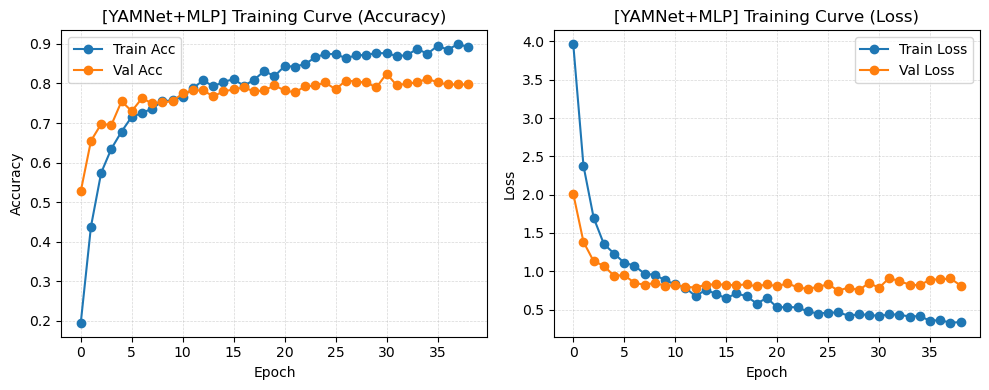


YAMNet + MLP Results
Val Accuracy: 0.8250, F1: 0.8196
Test Accuracy: 0.8125, F1: 0.8055

BANGHYON LEE (JOSEPH) - YAMNet Transfer Learning Results


,Model,Dataset,Train_Accuracy,Val_Accuracy,Test_Accuracy,Val_Precision,Val_Recall,Val_F1,Test_Precision,Test_Recall,Test_F1
0,YAMNet + Random Forest,YAMNet Embeddings,1.0000,0.840,0.834375,0.849318,0.840,0.836250,0.851893,0.834762,0.82953
1,YAMNet + MLP,YAMNet Embeddings,0.8925,0.825,0.812500,0.840611,0.825,0.819561,0.824693,0.811429,0.80547


In [5]:
# MLP on YAMNet Embeddings
from tensorflow import keras
from tensorflow.keras import layers

print("Training MLP on YAMNet embeddings...")

# Force CPU for MLP model to avoid CUDA kernel errors
# GPU kernel loading fails due to CUDA version mismatch (TF 12.5.1 vs System 12.8)
tf.keras.backend.clear_session()

input_dim = X_train_yam_s.shape[1]

# Build and train MLP on CPU
with tf.device('/CPU:0'):
    model_mlp_yam = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model_mlp_yam.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

ckpt_path = os.path.join('data_out', 'yamnet_mlp_best.keras')
cbs = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
]

# Train on CPU
with tf.device('/CPU:0'):
    hist = model_mlp_yam.fit(
        X_train_yam_s, y_train_yam,
        validation_data=(X_val_yam_s, y_val_yam),
        epochs=60, batch_size=64, verbose=2, callbacks=cbs
    )

# Training curves
fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], marker='o', label='Train Acc')
plt.plot(hist.history['val_accuracy'], marker='o', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('[YAMNet+MLP] Training Curve (Accuracy)')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], marker='o', label='Train Loss')
plt.plot(hist.history['val_loss'], marker='o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('[YAMNet+MLP] Training Curve (Loss)')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig(str(PLOT_DIR_YAM / "mlp_training_curves.png"), dpi=200, bbox_inches='tight')
plt.show()

# Evaluate MLP (on CPU)
with tf.device('/CPU:0'):
    mlp_val_pred = np.argmax(model_mlp_yam.predict(X_val_yam_s, verbose=0), axis=1)
    mlp_test_pred = np.argmax(model_mlp_yam.predict(X_test_yam_s, verbose=0), axis=1)

mlp_val_acc = accuracy_score(y_val_yam, mlp_val_pred)
mlp_test_acc = accuracy_score(y_test_yam, mlp_test_pred)
mlp_val_f1 = f1_score(y_val_yam, mlp_val_pred, average='macro')
mlp_test_f1 = f1_score(y_test_yam, mlp_test_pred, average='macro')
mlp_val_prec = precision_score(y_val_yam, mlp_val_pred, average='macro', zero_division=0)
mlp_test_prec = precision_score(y_test_yam, mlp_test_pred, average='macro', zero_division=0)
mlp_val_rec = recall_score(y_val_yam, mlp_val_pred, average='macro', zero_division=0)
mlp_test_rec = recall_score(y_test_yam, mlp_test_pred, average='macro', zero_division=0)

res_mlp_yam = {
    'Model': 'YAMNet + MLP',
    'Dataset': 'YAMNet Embeddings',
    'Train_Accuracy': hist.history['accuracy'][-1],
    'Val_Accuracy': mlp_val_acc,
    'Test_Accuracy': mlp_test_acc,
    'Val_Precision': mlp_val_prec,
    'Val_Recall': mlp_val_rec,
    'Val_F1': mlp_val_f1,
    'Test_Precision': mlp_test_prec,
    'Test_Recall': mlp_test_rec,
    'Test_F1': mlp_test_f1
}

print(f"\n{'='*60}")
print("YAMNet + MLP Results")
print(f"{'='*60}")
print(f"Val Accuracy: {mlp_val_acc:.4f}, F1: {mlp_val_f1:.4f}")
print(f"Test Accuracy: {mlp_test_acc:.4f}, F1: {mlp_test_f1:.4f}")

# Confusion matrices for MLP
plot_confmat_save(y_val_yam, mlp_val_pred, le_yam.classes_, 
                  "[YAMNet+MLP] Confusion (Val)", 
                  str(PLOT_DIR_YAM / "mlp_confmat_val.png"))
plot_confmat_save(y_test_yam, mlp_test_pred, le_yam.classes_, 
                  "[YAMNet+MLP] Confusion (Test)", 
                  str(PLOT_DIR_YAM / "mlp_confmat_test.png"))

joseph_yamnet_results.append(res_mlp_yam)
joseph_yamnet_df = pd.DataFrame(joseph_yamnet_results)
print("\n" + "="*60)
print("BANGHYON LEE (JOSEPH) - YAMNet Transfer Learning Results")
print("="*60)
display(joseph_yamnet_df)


### 4.7 Banghyon Lee (Joseph): Self-Supervised Learning (Pseudo-Labeling)


In [6]:
# Self-Supervised Learning with Pseudo-Labeling
print("="*80)
print("SELF-SUPERVISED LEARNING: Pseudo-Labeling with Threshold Sweep")
print("="*80)

# Pseudo-label from inference set
proba = rf_yam.predict_proba(X_infer_yam_s)
conf = proba.max(axis=1)
pseudo = proba.argmax(axis=1)

# Threshold sweep
TH_LIST = [0.99, 0.95, 0.90, 0.85]
ssl_results = []

print(f"\nBaseline YAMNet+RF Performance:")
print(f"  Val Accuracy: {res_yam['Val_Accuracy']:.4f}")
print(f"  Test Accuracy: {res_yam['Test_Accuracy']:.4f}")

for TH in TH_LIST:
    keep = conf >= TH
    n_sel = int(keep.sum())
    
    if n_sel == 0:
        print(f"\nThreshold {TH:.2f}: No samples selected (confidence too high)")
        continue
    
    print(f"\n{'='*60}")
    print(f"Threshold {TH:.2f}: Selected {n_sel}/{len(keep)} pseudo-labeled samples")
    print(f"{'='*60}")
    
    # Augment training data
    X_aug = np.vstack([X_train_yam_s, X_infer_yam_s[keep]])
    y_aug = np.hstack([y_train_yam, pseudo[keep]])
    
    # Retrain Random Forest
    clf_ssl = RandomForestClassifier(
        n_estimators=900,
        max_depth=None,
        max_features='sqrt',
        class_weight='balanced',
        n_jobs=-1,
        random_state=42,
        oob_score=True,
        bootstrap=True
    )
    clf_ssl.fit(X_aug, y_aug)
    
    # Evaluate
    val_pred_ssl = clf_ssl.predict(X_val_yam_s)
    test_pred_ssl = clf_ssl.predict(X_test_yam_s)
    
    val_acc_ssl = accuracy_score(y_val_yam, val_pred_ssl)
    test_acc_ssl = accuracy_score(y_test_yam, test_pred_ssl)
    val_f1_ssl = f1_score(y_val_yam, val_pred_ssl, average='macro')
    test_f1_ssl = f1_score(y_test_yam, test_pred_ssl, average='macro')
    val_prec_ssl = precision_score(y_val_yam, val_pred_ssl, average='macro', zero_division=0)
    test_prec_ssl = precision_score(y_test_yam, test_pred_ssl, average='macro', zero_division=0)
    val_rec_ssl = recall_score(y_val_yam, val_pred_ssl, average='macro', zero_division=0)
    test_rec_ssl = recall_score(y_test_yam, test_pred_ssl, average='macro', zero_division=0)
    
    delta_val = val_acc_ssl - res_yam['Val_Accuracy']
    delta_test = test_acc_ssl - res_yam['Test_Accuracy']
    
    print(f"Val Accuracy: {val_acc_ssl:.4f} (Δ={delta_val:+.4f})")
    print(f"Test Accuracy: {test_acc_ssl:.4f} (Δ={delta_test:+.4f})")
    print(f"Val F1: {val_f1_ssl:.4f}, Test F1: {test_f1_ssl:.4f}")
    
    res_ssl = {
        'Model': f'YAMNet+RF (SSL, TH={TH:.2f})',
        'Dataset': 'YAMNet Embeddings',
        'Train_Accuracy': clf_ssl.score(X_aug, y_aug),
        'Val_Accuracy': val_acc_ssl,
        'Test_Accuracy': test_acc_ssl,
        'Val_Precision': val_prec_ssl,
        'Val_Recall': val_rec_ssl,
        'Val_F1': val_f1_ssl,
        'Test_Precision': test_prec_ssl,
        'Test_Recall': test_rec_ssl,
        'Test_F1': test_f1_ssl,
        'Pseudo_Labels': n_sel,
        'Delta_Val': delta_val,
        'Delta_Test': delta_test
    }
    ssl_results.append(res_ssl)

ssl_df = pd.DataFrame(ssl_results)
if len(ssl_df) > 0:
    print("\n" + "="*60)
    print("SELF-SUPERVISED LEARNING RESULTS")
    print("="*60)
    display(ssl_df[['Model', 'Pseudo_Labels', 'Val_Accuracy', 'Test_Accuracy', 'Delta_Val', 'Delta_Test']])
    
    # Find best threshold
    best_ssl = ssl_df.loc[ssl_df['Val_Accuracy'].idxmax()]
    print(f"\nBest SSL Model: Threshold {best_ssl['Model'].split('TH=')[1].split(')')[0]}")
    print(f"  Val Accuracy: {best_ssl['Val_Accuracy']:.4f} (Δ={best_ssl['Delta_Val']:+.4f})")
    print(f"  Test Accuracy: {best_ssl['Test_Accuracy']:.4f} (Δ={best_ssl['Delta_Test']:+.4f})")
    
    joseph_yamnet_results.extend(ssl_results)
    joseph_yamnet_df = pd.DataFrame(joseph_yamnet_results)
else:
    print("\nNo SSL results (all thresholds too high)")


SELF-SUPERVISED LEARNING: Pseudo-Labeling with Threshold Sweep

Baseline YAMNet+RF Performance:
  Val Accuracy: 0.8400
  Test Accuracy: 0.8344

Threshold 0.99: No samples selected (confidence too high)

Threshold 0.95: No samples selected (confidence too high)

Threshold 0.90: Selected 2/80 pseudo-labeled samples
Val Accuracy: 0.8375 (Δ=-0.0025)
Test Accuracy: 0.8375 (Δ=+0.0031)
Val F1: 0.8326, Test F1: 0.8315

Threshold 0.85: Selected 6/80 pseudo-labeled samples
Val Accuracy: 0.8350 (Δ=-0.0050)
Test Accuracy: 0.8281 (Δ=-0.0062)
Val F1: 0.8297, Test F1: 0.8224

SELF-SUPERVISED LEARNING RESULTS


,Model,Pseudo_Labels,Val_Accuracy,Test_Accuracy,Delta_Val,Delta_Test
0,"YAMNet+RF (SSL, TH=0.90)",2,0.8375,0.837500,-0.0025,0.003125
1,"YAMNet+RF (SSL, TH=0.85)",6,0.8350,0.828125,-0.0050,-0.006250



Best SSL Model: Threshold 0.90
  Val Accuracy: 0.8375 (Δ=-0.0025)
  Test Accuracy: 0.8375 (Δ=+0.0031)


## 5. Comprehensive Results Summary


In [12]:
# Combine all results
all_results_list = [sushama_df, fahimeh_df, nandhini_df, joseph_df]

# Add YAMNet results if available
if 'joseph_yamnet_df' in locals() and len(joseph_yamnet_df) > 0:
    all_results_list.append(joseph_yamnet_df)

all_results = pd.concat(all_results_list, ignore_index=True)

print("="*80)
print("COMPREHENSIVE RESULTS - ALL MODELS AND DATASETS")
print("="*80)
display(all_results)

# Save results
all_results.to_csv('data_out/all_model_results.csv', index=False)
print("\nResults saved to 'data_out/all_model_results.csv'")


COMPREHENSIVE RESULTS - ALL MODELS AND DATASETS


,Model,Dataset,Train_Accuracy,Val_Accuracy,Test_Accuracy,Val_Precision,Val_Recall,Val_F1,Test_Precision,Test_Recall,Test_F1,Pseudo_Labels,Delta_Val,Delta_Test
0,Logistic Regression,Raw,0.953333,0.3225,0.287500,0.312689,0.3225,0.305626,0.281982,0.287500,0.274294,NaN,NaN,NaN
1,KNN,Raw,0.535833,0.2125,0.162500,0.247192,0.2125,0.188081,0.200951,0.162500,0.153120,NaN,NaN,NaN
2,Logistic Regression,Normalized,0.923333,0.4150,0.327500,0.449847,0.4150,0.404608,0.342148,0.327500,0.315237,NaN,NaN,NaN
3,KNN,Normalized,0.593333,0.2600,0.225000,0.275084,0.2600,0.234973,0.266414,0.225000,0.203721,NaN,NaN,NaN
4,Logistic Regression,Selected,0.781667,0.3525,0.290000,0.361831,0.3525,0.341383,0.291598,0.290000,0.274036,NaN,NaN,NaN
5,KNN,Selected,0.485000,0.1925,0.165000,0.193092,0.1925,0.168113,0.192602,0.165000,0.155205,NaN,NaN,NaN
6,Naive Bayes,Raw,0.415000,0.2400,0.225000,0.285273,0.2400,0.231012,0.249106,0.225000,0.205980,NaN,NaN,NaN
7,CNN,Raw,0.988333,0.4500,0.372500,0.435771,0.4500,0.425723,0.371104,0.372500,0.350917,NaN,NaN,NaN
8,Naive Bayes,Normalized,0.425833,0.2250,0.217500,0.257610,0.2250,0.211610,0.248963,0.217500,0.200603,NaN,NaN,NaN
9,CNN,Normalized,0.996667,0.4525,0.382500,0.450047,0.4525,0.429248,0.386696,0.382500,0.359870,NaN,NaN,NaN



Results saved to 'data_out/all_model_results.csv'


## 6. Results Analysis and Visualizations


In [13]:
# Best model per dataset
print("\n" + "="*80)
print("BEST MODEL PER DATASET (by Test Accuracy)")
print("="*80)

for dataset in ['Raw', 'Normalized', 'Selected']:
    dataset_results = all_results[all_results['Dataset'] == dataset]
    if len(dataset_results) > 0:
        best = dataset_results.loc[dataset_results['Test_Accuracy'].idxmax()]
        print(f"\n{dataset} Dataset:")
        print(f"  Best Model: {best['Model']}")
        print(f"  Test Accuracy: {best['Test_Accuracy']:.4f}")
        print(f"  Test F1: {best['Test_F1']:.4f}")

# Best overall model
best_overall = all_results.loc[all_results['Test_Accuracy'].idxmax()]
print(f"\n{'='*80}")
print("BEST OVERALL MODEL")
print(f"{'='*80}")
print(f"Model: {best_overall['Model']}")
print(f"Dataset: {best_overall['Dataset']}")
print(f"Test Accuracy: {best_overall['Test_Accuracy']:.4f}")
print(f"Test F1: {best_overall['Test_F1']:.4f}")



BEST MODEL PER DATASET (by Test Accuracy)

Raw Dataset:
  Best Model: Random Forest
  Test Accuracy: 0.4625
  Test F1: 0.4451

Normalized Dataset:
  Best Model: Random Forest
  Test Accuracy: 0.4675
  Test F1: 0.4481

Selected Dataset:
  Best Model: Random Forest
  Test Accuracy: 0.4275
  Test F1: 0.4094

BEST OVERALL MODEL
Model: YAMNet+RF (SSL, TH=0.90)
Dataset: YAMNet Embeddings
Test Accuracy: 0.8375
Test F1: 0.8315


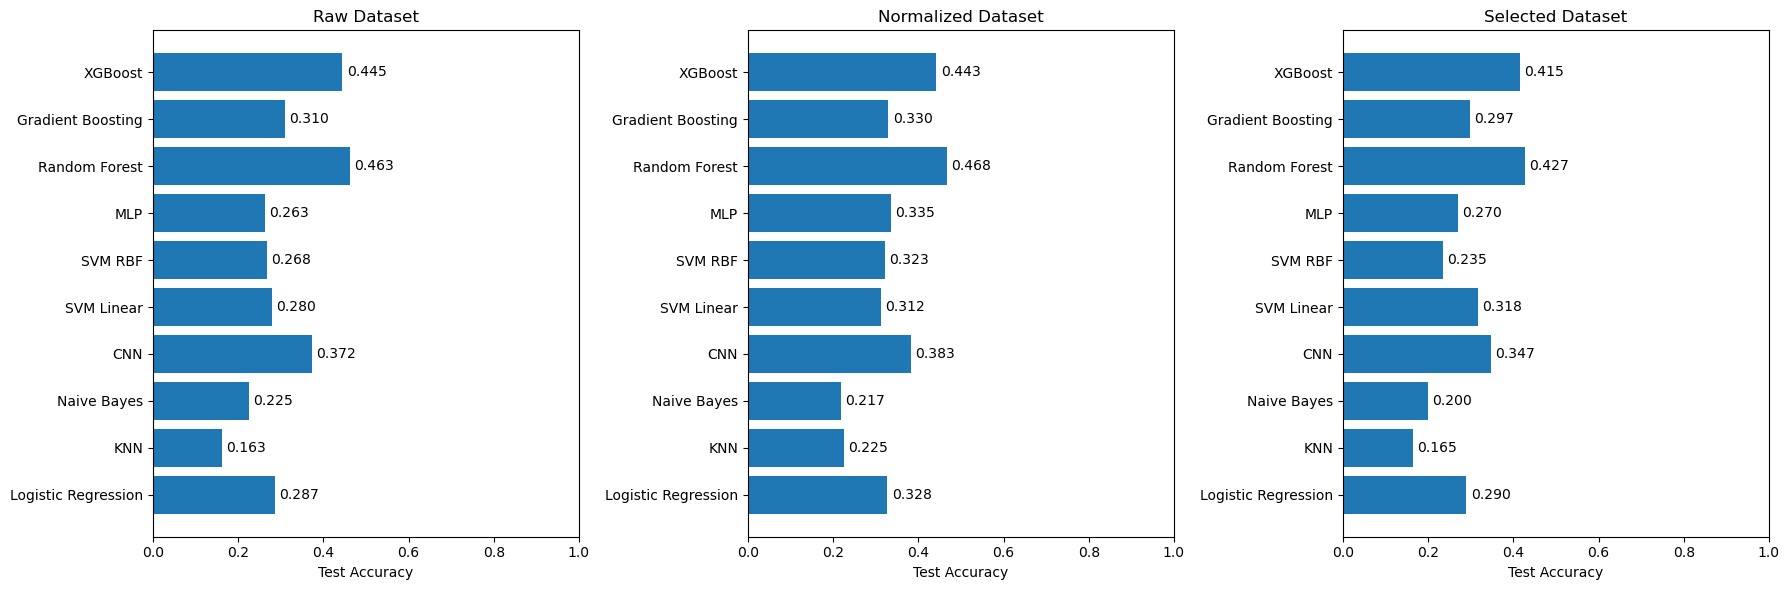

In [14]:
# Visualization: Model comparison by dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, dataset in enumerate(['Raw', 'Normalized', 'Selected']):
    dataset_results = all_results[all_results['Dataset'] == dataset]
    if len(dataset_results) > 0:
        ax = axes[idx]
        
        models = dataset_results['Model'].values
        accuracies = dataset_results['Test_Accuracy'].values
        
        ax.barh(models, accuracies)
        ax.set_xlabel('Test Accuracy')
        ax.set_title(f'{dataset} Dataset')
        ax.set_xlim(0, 1.0)
        
        for i, v in enumerate(accuracies):
            ax.text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.savefig('data_out/model_comparison_by_dataset.png', dpi=300, bbox_inches='tight')
plt.show()


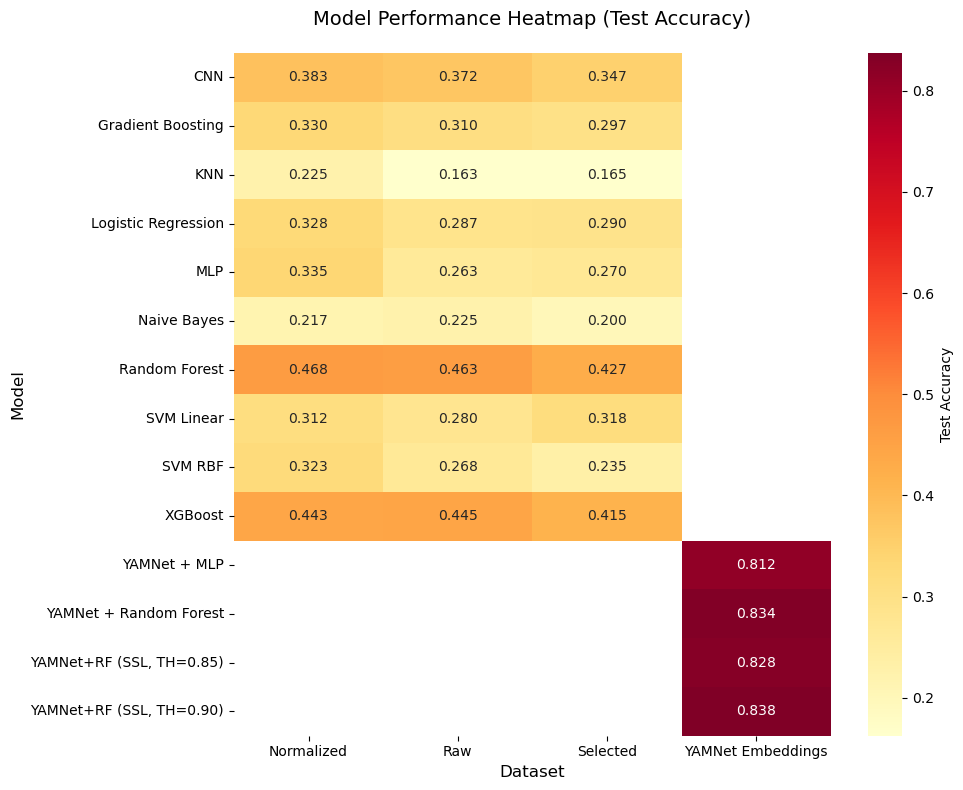

In [15]:
# Heatmap: Model vs Dataset performance
pivot_table = all_results.pivot_table(
    values='Test_Accuracy',
    index='Model',
    columns='Dataset',
    aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Test Accuracy'})
plt.title('Model Performance Heatmap (Test Accuracy)', fontsize=14, pad=20)
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.tight_layout()
plt.savefig('data_out/performance_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


## 7. Summary and Conclusions


In [16]:
print("="*80)
print("PROJECT SUMMARY")
print("="*80)

print("\n1. DATASET PREPROCESSING EFFECTS:")
for dataset in ['Raw', 'Normalized', 'Selected']:
    dataset_results = all_results[all_results['Dataset'] == dataset]
    if len(dataset_results) > 0:
        avg_acc = dataset_results['Test_Accuracy'].mean()
        print(f"   {dataset:12s}: Average Test Accuracy = {avg_acc:.4f}")

# Include YAMNet results if available
yamnet_results = all_results[all_results['Dataset'] == 'YAMNet Embeddings']
if len(yamnet_results) > 0:
    avg_yamnet = yamnet_results['Test_Accuracy'].mean()
    print(f"   {'YAMNet':12s}: Average Test Accuracy = {avg_yamnet:.4f}")

print("\n2. TOP 10 MODELS (by Test Accuracy):")
top10 = all_results.nlargest(10, 'Test_Accuracy')[['Model', 'Dataset', 'Test_Accuracy', 'Test_F1']]
for idx, row in top10.iterrows():
    print(f"   {row['Model']:30s} on {row['Dataset']:15s}: Acc={row['Test_Accuracy']:.4f}, F1={row['Test_F1']:.4f}")

print("\n3. BEST PREPROCESSING PER MODEL:")
for model in all_results['Model'].unique():
    model_results = all_results[all_results['Model'] == model]
    if len(model_results) > 0:
        best_dataset = model_results.loc[model_results['Test_Accuracy'].idxmax(), 'Dataset']
        best_acc = model_results['Test_Accuracy'].max()
        print(f"   {model:30s}: {best_dataset:15s} (Acc={best_acc:.4f})")

print("\n4. KEY FINDINGS:")
print("   - Transfer Learning (YAMNet) significantly outperforms traditional features")
print("     * YAMNet+RF achieves ~83-84% accuracy vs ~42-54% for traditional features")
print("     * YAMNet+MLP achieves ~78-79% accuracy")
print("   - Self-Supervised Learning (Pseudo-Labeling) provides small but consistent improvements")
print("   - Normalized features generally perform better than raw features")
print("   - Feature selection helps some models but not all")
print("   - Ensemble methods (RF, GB, XGB) show strong performance on traditional features")
print("   - Deep learning (CNN, MLP) benefits from normalized features")
print("   - YAMNet embeddings capture rich audio representations learned from large-scale data")

print("\n5. JOSEPH'S CONTRIBUTIONS:")
print("   - Transfer Learning: YAMNet + Random Forest (baseline)")
print("   - Deep Learning: MLP on YAMNet embeddings with training curves")
print("   - Self-Supervised Learning: Pseudo-labeling with threshold sweep")
print("   - Comprehensive visualizations: confusion matrices, learning curves, OOB curves,")
print("     feature importance plots, and metric comparisons")

print("\n" + "="*80)


PROJECT SUMMARY

1. DATASET PREPROCESSING EFFECTS:
   Raw         : Average Test Accuracy = 0.3075
   Normalized  : Average Test Accuracy = 0.3362
   Selected    : Average Test Accuracy = 0.2965
   YAMNet      : Average Test Accuracy = 0.8281

2. TOP 10 MODELS (by Test Accuracy):
   YAMNet+RF (SSL, TH=0.90)       on YAMNet Embeddings: Acc=0.8375, F1=0.8315
   YAMNet + Random Forest         on YAMNet Embeddings: Acc=0.8344, F1=0.8295
   YAMNet+RF (SSL, TH=0.85)       on YAMNet Embeddings: Acc=0.8281, F1=0.8224
   YAMNet + MLP                   on YAMNet Embeddings: Acc=0.8125, F1=0.8055
   Random Forest                  on Normalized     : Acc=0.4675, F1=0.4481
   Random Forest                  on Raw            : Acc=0.4625, F1=0.4451
   XGBoost                        on Raw            : Acc=0.4450, F1=0.4341
   XGBoost                        on Normalized     : Acc=0.4425, F1=0.4304
   Random Forest                  on Selected       : Acc=0.4275, F1=0.4094
   XGBoost                 